In [1]:
import pandas as pd
import numpy  as np
from sklearn.cluster import KMeans
import seaborn as sns
import chardet
import re
from collections import Counter


In [2]:
# importing csvs
materials_from_components = pd.read_csv('/Users/pablosoriano/Documents/Data Science/bbsr-challenge/all_uuid_materials_from_components.csv')
obd_with_pollutants = pd.read_csv("pollutant_labeled_obd_translated.csv", sep=";", low_memory=False)

# Data Wrangling


In [3]:
# info
materials_from_components.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   t_value              2724 non-null   int64  
 1   material_name        2724 non-null   object 
 2   thickness_mm         2724 non-null   object 
 3   database             2724 non-null   object 
 4   life_cycle           2724 non-null   object 
 5   process              2724 non-null   object 
 6   uuid                 2724 non-null   object 
 7   subcomponent_id      2724 non-null   int64  
 8   main_component_id    2724 non-null   float64
 9   main_component_name  2724 non-null   object 
 10  subcomponent_name    2724 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 234.2+ KB


In [4]:
# null values 
materials_from_components.isnull().sum()

t_value                0
material_name          0
thickness_mm           0
database               0
life_cycle             0
process                0
uuid                   0
subcomponent_id        0
main_component_id      0
main_component_name    0
subcomponent_name      0
dtype: int64

In [5]:
# removing duplicates from materials_from_components
materials_sorted = materials_from_components.sort_values(by=["process","database"], ascending=[True, False]) 

# Standarizing values in the database column
database_names = materials_sorted["database"].unique()

# "Ökobilanzierung-Rechenwerte 2023 V1.3" = "OBD_2023_"
materials_sorted

#remove material_name column (keep "process")
materials_sorted = materials_sorted.drop(columns=["material_name"])

ideally I would get all the datasets. I don't have time now so I will work with what I have. Need to decide wich version to keep. To match as many materials as possible, i will merge both df keeping all dataset versions, and only after remove duplicates

In [6]:
database_names

array(['Ökobilanzierung-Rechenwerte 2023 V1.3', 'OeKOBAUDAT_2016-I_A1',
       'OBD_2024_A2', 'OBD_2023_I_A2', 'OBD_2023_I_A1', 'OBD_2021_II_A1',
       'OBD_2020_II_A1', 'Ökobau.dat 2011', 'Ökobau.dat 2009',
       'ÖBD_2024_A2_RMI'], dtype=object)

In [7]:
# standarize the names of the databases
materials_sorted["database"] = materials_sorted["database"].replace({
    "Ökobilanzierung-Rechenwerte 2023 V1.3": "OBD_2023_",
    "OeKOBAUDAT_2016-I_A1": "OBD_2020_",
    "Ökobau.dat 2011": "OBD_2011_",
    "Ökobau.dat 2009": "OBD_2009_",
    "ÖBD_2024_A2_RMI": "OBD_2024_A2",
})

In [8]:
mineral_wool = obd_with_pollutants[obd_with_pollutants["UUID"]=="ac779922-219f-4730-9aef-a7da84d334c1"]


#REVIEW - why do i have so many entries!!

In [9]:
# removing duplicates from obd_with_pollutants, keeping one for each module
obd_with_pollutants_sorted = obd_with_pollutants.sort_values(by=["UUID","Modul"], ascending=[True, True])
# removing duplicates from obd_with_pollutants, keeping one for each module
obd_with_pollutants_clean = obd_with_pollutants_sorted.drop_duplicates(subset=["UUID","Modul"], keep="first") # done in the previous step




In [10]:
# checking with an example
mineral_wool_deduped = obd_with_pollutants_clean[obd_with_pollutants_clean["UUID"]=="ac779922-219f-4730-9aef-a7da84d334c1"]


In [11]:
mineral_wool_deduped 

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,oekobaudatProcessUuid,eolCategoryName,productId,productName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor,Fremd-/Störstoffbeschreibung,Störstoffklasse,Fremd-/Störstoffbeschreibung (EN)
387,ac779922-219f-4730-9aef-a7da84d334c1,20.24.070,Mineralwolle (Boden-Dämmung),Mineral wool (floor insulation),'Dämmstoffe' / 'Mineralwolle' / 'Mineralwolle','Insulation materials' / 'Mineral wool' / 'Min...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,ac779922-219f-4730-9aef-a7da84d334c1,Mineralwolle Steinwolle,301,Mineralwolle (Innenausbau-DÃ¤mmung),Dep-,RC-,0.5,ohne Fremd-/Störstoffe,S0,Without foreign/interference substances


In [12]:
mineral_wool_original = obd_with_pollutants[obd_with_pollutants["UUID"]=="ac779922-219f-4730-9aef-a7da84d334c1"]

In [13]:
mineral_wool_original

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,oekobaudatProcessUuid,eolCategoryName,productId,productName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor,Fremd-/Störstoffbeschreibung,Störstoffklasse,Fremd-/Störstoffbeschreibung (EN)
387,ac779922-219f-4730-9aef-a7da84d334c1,20.24.070,Mineralwolle (Boden-Dämmung),Mineral wool (floor insulation),'Dämmstoffe' / 'Mineralwolle' / 'Mineralwolle','Insulation materials' / 'Mineral wool' / 'Min...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,ac779922-219f-4730-9aef-a7da84d334c1,Mineralwolle Steinwolle,301,Mineralwolle (Innenausbau-DÃ¤mmung),Dep-,RC-,0.5,ohne Fremd-/Störstoffe,S0,Without foreign/interference substances
388,ac779922-219f-4730-9aef-a7da84d334c1,20.24.070,Mineralwolle (Boden-Dämmung),Mineral wool (floor insulation),'Dämmstoffe' / 'Mineralwolle' / 'Mineralwolle','Insulation materials' / 'Mineral wool' / 'Min...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,ac779922-219f-4730-9aef-a7da84d334c1,Mineralwolle Steinwolle,301,Mineralwolle (Innenausbau-DÃ¤mmung),Dep-,RC-,0.5,"kaschierung, gipskarton, putze, klebespachtel",S3,"Killage, plasterboard, cleaning, adhesive spatula"
389,ac779922-219f-4730-9aef-a7da84d334c1,20.24.070,Mineralwolle (Boden-Dämmung),Mineral wool (floor insulation),'Dämmstoffe' / 'Mineralwolle' / 'Mineralwolle','Insulation materials' / 'Mineral wool' / 'Min...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,ac779922-219f-4730-9aef-a7da84d334c1,Mineralwolle Steinwolle,300,Mineralwolle (Flachdach-DÃ¤mmung),Dep-,RC-,0.5,ohne Fremd-/Störstoffe,S0,Without foreign/interference substances
390,ac779922-219f-4730-9aef-a7da84d334c1,20.24.070,Mineralwolle (Boden-Dämmung),Mineral wool (floor insulation),'Dämmstoffe' / 'Mineralwolle' / 'Mineralwolle','Insulation materials' / 'Mineral wool' / 'Min...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,ac779922-219f-4730-9aef-a7da84d334c1,Mineralwolle Steinwolle,300,Mineralwolle (Flachdach-DÃ¤mmung),Dep-,RC-,0.5,"kaschierung, gipskarton, putze, klebespachtel",S3,"Killage, plasterboard, cleaning, adhesive spatula"
391,ac779922-219f-4730-9aef-a7da84d334c1,20.24.070,Mineralwolle (Boden-Dämmung),Mineral wool (floor insulation),'Dämmstoffe' / 'Mineralwolle' / 'Mineralwolle','Insulation materials' / 'Mineral wool' / 'Min...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,ac779922-219f-4730-9aef-a7da84d334c1,Mineralwolle Steinwolle,299,Mineralwolle (Fassaden-DÃ¤mmung),Dep-,RC-,0.5,ohne Fremd-/Störstoffe,S0,Without foreign/interference substances
392,ac779922-219f-4730-9aef-a7da84d334c1,20.24.070,Mineralwolle (Boden-Dämmung),Mineral wool (floor insulation),'Dämmstoffe' / 'Mineralwolle' / 'Mineralwolle','Insulation materials' / 'Mineral wool' / 'Min...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,ac779922-219f-4730-9aef-a7da84d334c1,Mineralwolle Steinwolle,299,Mineralwolle (Fassaden-DÃ¤mmung),Dep-,RC-,0.5,"kaschierung, gipskarton, putze, klebespachtel",S3,"Killage, plasterboard, cleaning, adhesive spatula"
393,ac779922-219f-4730-9aef-a7da84d334c1,20.24.070,Mineralwolle (Boden-Dämmung),Mineral wool (floor insulation),'Dämmstoffe' / 'Mineralwolle' / 'Mineralwolle','Insulation materials' / 'Mineral wool' / 'Min...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,ac779922-219f-4730-9aef-a7da84d334c1,Mineralwolle Steinwolle,298,Mineralwolle (Boden-DÃ¤mmung),Dep-,RC-,0.5,ohne Fremd-/Störstoffe,S0,Without foreign/interference substances
394,ac779922-219f-4730-9aef-a7da84d334c1,20.24.070,Mineralwolle (Boden-Dämmung),Mineral wool (floor insulation),'Dämmstoffe' / 'Mineralwolle' / 'Mineralwolle','Insulation materials' / 'Mineral wool' / 'Min...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,ac779922-219f-4730-9aef-a7da84d334c1,Mineralwolle Steinwolle,298,Mineralwolle (Boden-DÃ¤mmung),Dep-,RC-,0.5,"kaschierung, gipskarton, putze, klebespachtel",S3,"Killage, plasterboard, cleaning, adhesive spatula"
395,ac779922-

In [14]:
print("total materials matched with pollutants: ",len(obd_with_pollutants))

total materials matched with pollutants:  1069


In [15]:
#getting more data# detect files encoding
with open("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/documentation/OBD_2019_I_2025-04-24T22_53_34.csv", "rb") as f:
    result = chardet.detect(f.read(100000))  # Read first 100,000 bytes
    print(result)
    
oko_2019_I_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/documentation/OBD_2019_I_2025-04-24T22_53_34.csv", delimiter=";", encoding = result["encoding"], low_memory=False)
oko_2019_II_df= pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/documentation/OBD_2019_II_2025-04-24T22_53_28.csv", delimiter=";", encoding = result["encoding"], low_memory=False)
oko_2019_III_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/documentation/OBD_2019_III_2025-04-24T22_53_20.csv", delimiter=";", encoding = result["encoding"], low_memory=False)
oko_2020_I_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/documentation/OBD_2020_I_2025-04-24T22_53_09.csv", delimiter=";", encoding = result["encoding"], low_memory=False)


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [16]:
oko_merged_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/obd_merged.csv",sep=";", encoding = result["encoding"], low_memory=False)

In [17]:
obd_with_pollutants_clean["Name (en)"].nunique()

89

In [18]:
oko_merged_df["Name (en)"].nunique()

2495

In [19]:
# Assesing if to merge the dataframes or just keep the one from 2024
oko_combined_df = pd.concat([oko_2019_I_df, oko_2019_II_df, oko_2019_III_df,oko_2020_I_df], ignore_index=True)

# Compare unique material names between datasets
materials_2019_2020 = set(oko_combined_df["Name (en)"].dropna().unique())
materials_merged = set(oko_merged_df["Name (en)"].dropna().unique())

# Find materials in 2020 and 2023 that are not in 2024
unique_2019_2020 = materials_2019_2020 - materials_merged

# Count them
unique_2020_count = len(unique_2019_2020)


unique_2020_count, 

(154,)

In [20]:
oko_combined_2019_2024 = pd.concat([oko_combined_df, oko_2019_II_df, oko_2019_III_df,oko_2020_I_df], ignore_index=True)


forget about the modules. one oko material to all the possible pollutants for the respective eolcategory
maybe I can increase the match by taking into consideration the env. impact metrics? Could work if we can associate in the know bootstraped df the metrics to a eol category. would need to do an avg of the metrics between all the modules of same product. machine learning with labels (like wine)

🎯 1. Are environmental impacts correlated to EoL scenarios/categories?
Short answer: sometimes, but not reliably. Here's why:

Environmental Indicators (A2)	EoL Scenarios & Categories	Are they correlated?
Production impacts (e.g., GWP, FW)	EoL scenarios like Recycling (C3/D), Landfilling (C4)	❌ Only weakly.
Waste-related outputs (e.g., SM, CRU, MFR)	EoL categories (e.g., Reuse, Recycle, Dispose)	✅ More correlated!
🔎 Why?

A1-A3 impacts (like GWP or AP) measure production, not end-of-life behavior.

SM (Secondary Material Use), CRU (Components for Reuse), MFR (Materials for Recycling) directly describe circularity outcomes, so they're much better signals for predicting EoL fate.

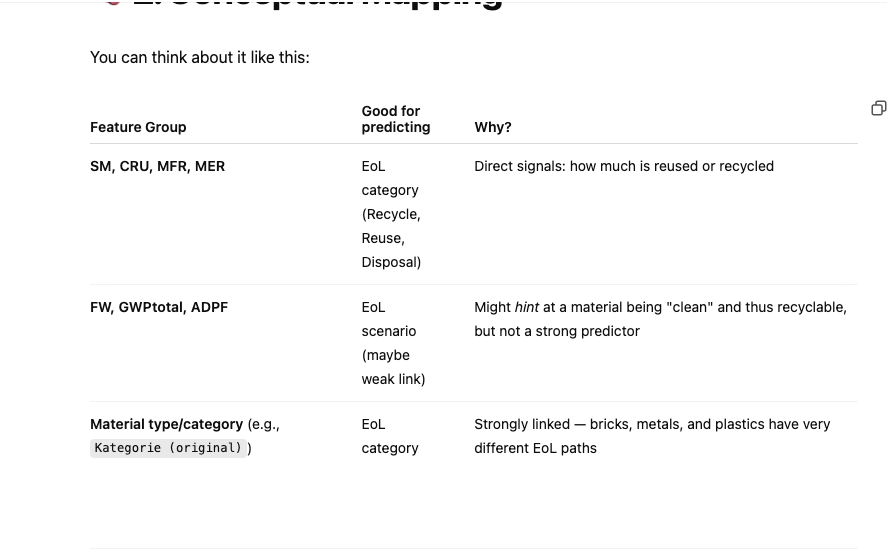

Best Features to Focus On for EoL Predictions

If you want to predict EoL category or EoL scenario, prioritize:

Directly useful:
SM (Secondary Material Use) – direct reuse

CRU (Components for Reuse) – disassembly potential

MFR (Materials for Recycling) – recycling potential

MER (Materials for Energy Recovery) – incineration likely

Helpful contextual features:
Typ (Dataset Type: generic vs specific)

Konformität (standard compliance, e.g., EN15804 A1 vs A2)

Kategorie (original) (Material type/category)

Weaker features (indirect signals):
GWPtotal (A2), FW, ADPF (A2), etc.

Can help refine predictions, but don't rely on them alone



In [21]:
# correlation matrix
# Re-import libraries after reset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Reload the full Ökobaudat dataset
df_multi_module = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/obd_with_eol_multiple_modules.csv", delimiter=";")

# Select relevant features
eol_target = "eolCategoryName"

circularity_features_direct = ["SM", "CRU", "MFR", "MER"]
circularity_features_indirect = [
    "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)",
    "AP (A2)", "POCP (A2)", "ADPF (A2)", "FW", "WDP (A2)"
]

all_features = circularity_features_direct + circularity_features_indirect

# Filter dataset
df_circularity = df_multi_module[circularity_features_direct + circularity_features_indirect + [eol_target]].dropna()

# Encode target for modeling
eol_encoder = LabelEncoder()
df_circularity["eol_label"] = eol_encoder.fit_transform(df_circularity[eol_target])

# Correlation matrix
correlation_matrix = df_circularity[all_features + ["eol_label"]].corr()


# Return shape and a sample
df_circularity.shape, df_circularity.head(3)


/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_2726/3755750230.py:9: DtypeWarning: Columns (76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df_multi_module = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/obd_with_eol_multiple_modules.csv", delimiter=";")


((1082, 14),
        SM  CRU     MFR  MER  GWPtotal (A2)  GWPbiogenic (A2)  GWPfossil (A2)  \
 1373  0.0  0.0  0.0000  0.0      -0.001572          0.000024       -0.001578   
 1374  0.0  0.0  0.7275  0.0       0.007104          0.000031        0.007003   
 1375  0.0  0.0  0.0000  0.0       0.004260          0.000022        0.004158   
 
        AP (A2)  POCP (A2)  ADPF (A2)        FW  WDP (A2)  \
 1373 -0.000006  -0.000006  -0.020864 -0.000004 -0.000045   
 1374  0.000043   0.000041   0.106828  0.000030  0.000959   
 1375  0.000005   0.000005   0.054593  0.000006  0.000030   
 
                eolCategoryName  eol_label  
 1373  Kies / Schotter / Splitt         53  
 1374  Kies / Schotter / Splitt         53  
 1375  Kies / Schotter / Splitt         53  )

Quick Observations
Direct circularity features (SM, CRU, MFR, MER) have higher correlations with eolCategoryName than production impact features (like GWPtotal (A2) or FW).

Indirect features still show some weak patterns — for example, certain high GWP materials tend toward landfill — but far less predictive than circularity metrics.

🧠 Key Insight
✅ Low feature-label correlation doesn't necessarily mean poor model performance!

Why?

Non-linear models (like Random Forests, XGBoost) can still capture complex patterns across multiple weakly correlated features.

In real-world ML, it's very common that no single feature strongly predicts the target — but combinations of features do.

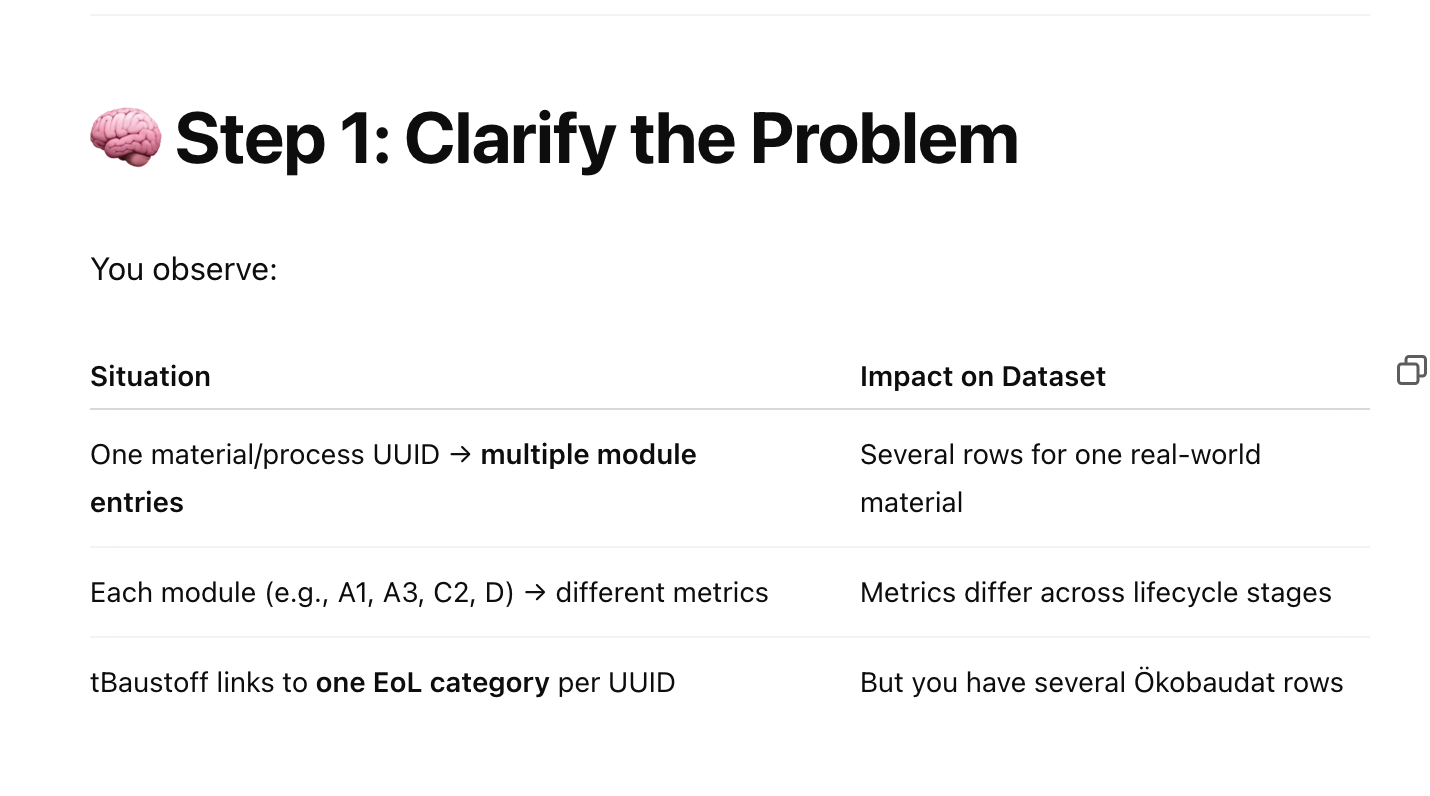

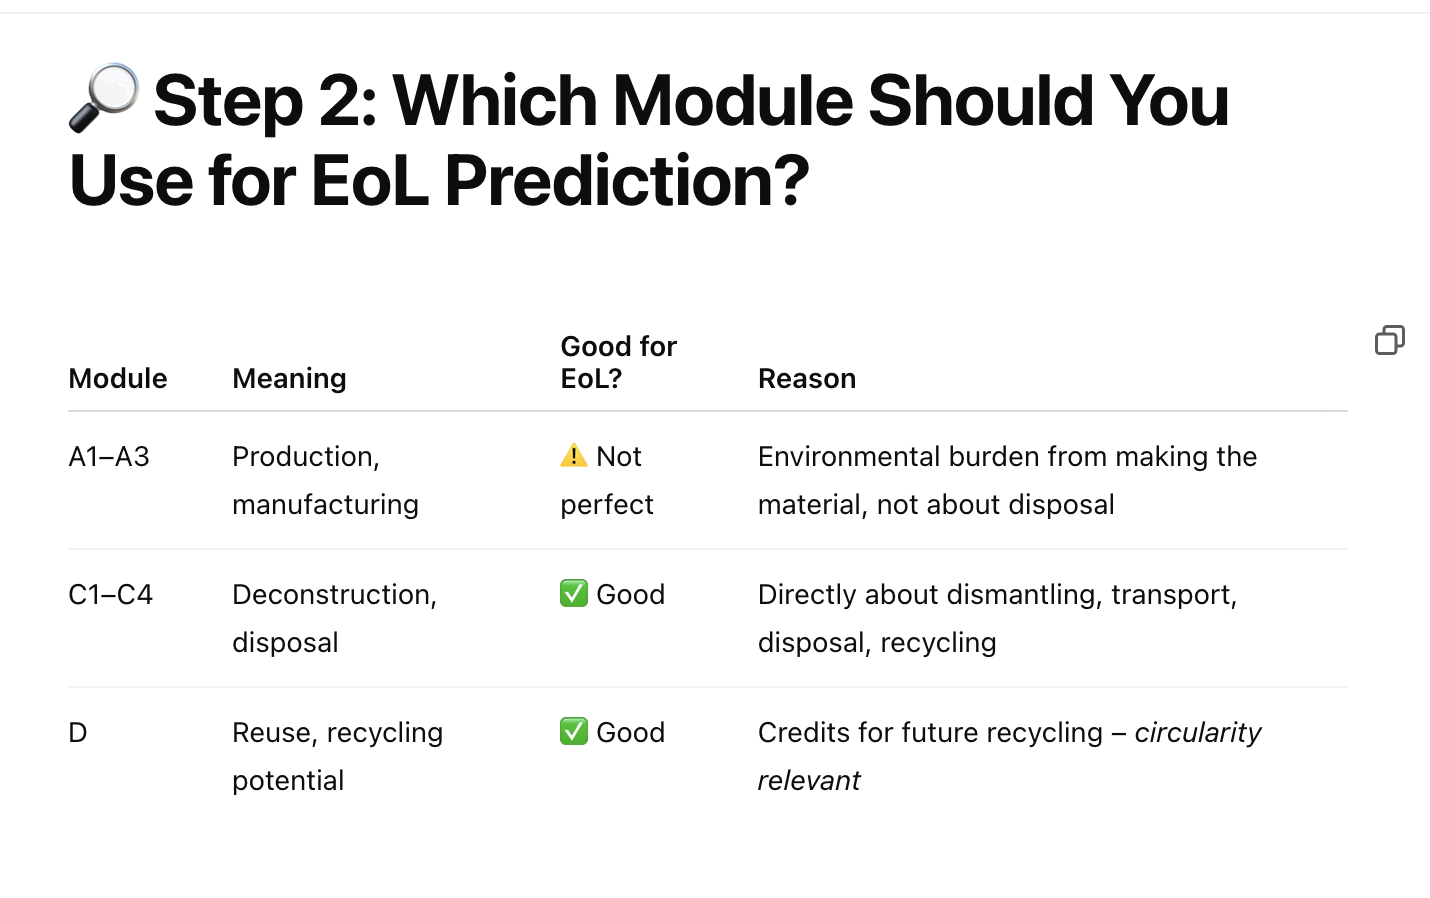

🚨 Key Insight
Modules C and D are the ones most directly linked to the material’s end-of-life.

Modules A1–A3 (production) are only indirectly related.

Module-Selective Aggregation
✅ Here's a better, principled version of your idea:

ONLY average or aggregate the C and D modules (C1–C4, D).

Optionally, you can keep A1–A3 separate (if you want additional context).

Build one row per UUID:

Mean of environmental metrics from C1–C4 + D

Plus optional averages from A1–A3 if desired

Thus:
Per material UUID, you have one row = averaged (or summarized) C+D environmental profile.

In [22]:
df_multi_module = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/obd_with_eol_multiple_modules.csv", delimiter=";")

/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_2726/514701812.py:1: DtypeWarning: Columns (76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df_multi_module = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/obd_with_eol_multiple_modules.csv", delimiter=";")


In [23]:
df_multi_module.shape

(18118, 78)

## Aggregating environmental metrics colummns by avg between different modules

In [24]:
df_multi_module["Modul"].unique()

array(['C4', 'C3', 'C1', 'A3', 'A2', 'A1', 'A1-A3', 'D', 'B2', 'B1', 'A5',
       'A4', 'C2', 'B6', 'B5', 'B4', 'B3', 'B7'], dtype=object)

In [25]:
df_multi_module.groupby("Modul").size()

Modul
A1        371
A1-A3    2053
A2        371
A3        371
A4       1133
A5       1190
B1        701
B2        526
B3        364
B4        354
B5        352
B6        561
B7        372
C1       1615
C2       2027
C3       1999
C4       1697
D        2061
dtype: int64

In [26]:
# Step 1: Filter to C and D modules
eol_relevant_modules = ["C1", "C2", "C3", "C4", "D"]
df_eol = df_multi_module[df_multi_module["Modul"].isin(eol_relevant_modules)].copy()

# Step 2: Identify environmental metrics columns
environmental_metrics = [
    "SM", "CRU", "MFR", "MER", "FW",
    "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)",
    "AP (A2)", "POCP (A2)", "ADPF (A2)", "ADPE (A2)", "WDP (A2)",
    "EPmarine (A2)", "EPfreshwater (A2)", "EPterrestrial (A2)",
    "ODP (A2)"
]

# Keep only rows with non-null UUIDs and EoL category (for labeling)
# df_eol = df_eol.dropna(subset=["UUID", "eolCategoryName"])

# Step 3: Group by UUID and aggregate
df_eol_grouped = df_eol.groupby(["UUID", "eolCategoryName"])[environmental_metrics].mean().reset_index()



df_eol_grouped.shape


(250, 19)

I now have 250 unique materials (UUIDs)

Each one is represented by the average environmental metrics relevant for end-of-life (EoL) prediction

Each row is also linked to its eolCategoryName from the tBaustoff mapping

In [27]:
df_eol_grouped.head(3)

,UUID,eolCategoryName,SM,CRU,MFR,MER,FW,GWPtotal (A2),GWPbiogenic (A2),GWPfossil (A2),AP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),EPmarine (A2),EPfreshwater (A2),EPterrestrial (A2),ODP (A2)
0,004f3f4e-5bb8-4d9e-a104-6999a9e8ad5b,Gipsputz (auf Massivbaustoff),0.0,0.0,0.00,0.0,0.028384,10.356659,0.992178,9.284031,0.055082,0.043846,122.251881,7.912296e-07,0.859094,0.014420,0.000022,0.159783,2.078755e-11
1,01726dcb-d5e9-44d2-b1df-f7fabc350723,KSTProfil,0.0,0.0,0.00,0.0,0.001812,0.583291,-0.003537,0.586846,-0.000313,-0.000341,-6.260265,-4.183486e-08,0.109075,-0.000130,-0.000001,-0.001017,-6.881600e-12
2,01f45a03-460d-4e55-b5c9-72d3e8eda18e,Porenbeton-Granulat,0.0,0.0,72.75,0.0,0.003170,1.009351,0.007926,0.987841,0.004597,0.004568,14.442185,4.066871e-07,0.094583,0.001515,0.000002,0.016941,7.339250e-13


In [28]:
# quick random forest to predict eolCategoryName on this new dataset (df_eol_grouped)

# Re-import libraries after reset
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


# Prepare features and target
X = df_eol_grouped[environmental_metrics]
y = df_eol_grouped["eolCategoryName"]

# Encode target labels
eol_encoder = LabelEncoder()
y_encoded = eol_encoder.fit_transform(y)

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred = cross_val_predict(rf_model, X, y_encoded, cv=cv)

# Classification report
report = classification_report(y_encoded, y_pred, target_names=eol_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion matrix
conf_mat = confusion_matrix(y_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=eol_encoder.classes_)

# Train final model for feature importances
rf_model.fit(X, y_encoded)
importances = pd.Series(rf_model.feature_importances_, index=environmental_metrics).sort_values(ascending=False)

# # Plotting confusion matrix
# fig, ax = plt.subplots(figsize=(10, 10))
# disp.plot(ax=ax, cmap='Blues', values_format='d')
# plt.xticks(rotation=90)
# plt.tight_layout()




/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedM

In [29]:
report

{'Alu Guss': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Alu unbeschichtet od. eloxiert (Sz. Knetleg zu Guss)': {'precision': 0.2,
  'recall': 0.5,
  'f1-score': 0.2857142857142857,
  'support': 2.0},
 'Alu-Pfosten-Riegel-Konstr. ungedÃ¤mmt': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 2.0},
 'Asphalt (Hochbau)': {'precision': 0.3333333333333333,
  'recall': 0.5,
  'f1-score': 0.4,
  'support': 2.0},
 'Asphalt (Infrastrukturbau)': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Beton Standard (ohne Bewehr.)': {'precision': 0.6923076923076923,
  'recall': 0.6923076923076923,
  'f1-score': 0.6923076923076923,
  'support': 13.0},
 'Betondachstein': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Bitubahn (ggf. mit Glasvlies)': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 3.0},
 'Bitumenkaltkleber, Glasvlies, Glasfaserarmierung': {'precision': 1.0,
  'recal

Improving results:

Add material category features (e.g., is_brick, is_concrete) to training set

Retrain with class balancing (class_weight="balanced")

In [30]:
# count of rows with each eolCategoryName
eol_count = df_eol_grouped.groupby("eolCategoryName").size()
eol_count

eolCategoryName
Alu Guss                                                                       1
Alu unbeschichtet od. eloxiert (Sz. Knetleg zu Guss)                           2
Alu-Pfosten-Riegel-Konstr. ungedÃ¤mmt                                          2
Asphalt (Hochbau)                                                              2
Asphalt (Infrastrukturbau)                                                     1
                                                                              ..
Zink                                                                           1
faserverstÃ¤rkt                                                                1
mineral. Putz, MÃ¶rtel, Kleber                                                 6
organ. Putz                                                                    2
organ. Putz (Fliesenkleber StÃ¶rstoff, Masse Einstuf. ident zu organ. Putz)    1
Length: 106, dtype: int64

# semi-supervised + active learning strategy

Use the EoL Category prediction model to:

- Pseudo-label high-confidence entries

- Expand training set

- Manually label uncertain cases

- Then use expanded EoL labels to help in pollutant prediction.

1) Clean & Explore the 210-Row Labeled Dataset
Let's confirm:

Which columns you're using as features (e.g., GWPtotal (A2), SM, FW, PERE, etc.)

The format of the pollutant labels — single or multi-label (multiple pollutants per material?)

Class balance (e.g., are some pollutants much more frequent than others?)


2) Train a Baseline Model on These 210 Rows
- Probably start with a Random Forest, Logistic Regression, or XGBoost depending on how many classes you have.

- Evaluate with stratified 5-fold cross-validation

- Metrics: macro F1, confusion matrix, class support

- This model will be used to:

- Generate pseudo-labels (for semi-supervised expansion)

- Select uncertain samples (for active learning)

3) Semi-Supervised Labeling (High-Confidence Bootstrapping)
Use the trained model to predict labels on unlabeled OBD entries

Add entries where the prediction confidence > threshold (e.g., 90%)

Iterate: retrain on combined labeled + confident pseudo-labeled set

Optional: Visualize class distribution and confidence thresholds.

4) Active Learning
You can:

Pick top 20–50 entries where the model is most uncertain (e.g., prediction confidence ~0.5)

Manually label them — or prioritize with your pollutant domain rules

Retrain model and repeat



Leverage Domain Knowledge: Rules for Default Labels

Some pollutants can be rule-assigned with decent confidence:

EPS / XPS → often include HBCD or blowing agents

PVC → linked with plasticizers

Paints / coatings → often include solvents

Bitumen products → sometimes contain PAHs

can use rules like this
if "EPS" in productName or "Polystyrol" in category:
    label = "HBCD"


Strategy | What You Would Do | Pros | Cons
1. Expand EoL Categories first (your idea) | 
    What would i do? Predict and expand EoL categories, then later use EoL categories to enrich pollutant prediction. 
    Pros: ✅ Easier to predict EoL than pollutants (signal is stronger)  ✅ Much safer for semi-supervised labeling (lower noise)  ✅ Adds interpretability: "why do I predict this pollutant?" → because EoL is XYZ | 
    Cons: ❌ Indirect expansion — still have to predict pollutants afterward
2. Expand Pollutant labels directly | 
    What would I do| 
    Pros: ✅ Straight to the end-goal: bigger pollutant training set  ✅ Potentially faster | 
    Cons: ❌ Pollutant labels are much noisier and harder to predict  ❌ Higher risk of adding errors early (pollutants are sensitive to subtle material differences)

EoL Categories are easier to predict reliably — you can get higher-confidence pseudo-labels.

Pollutants are harder to predict — and an early mistake could cascade errors into your model.

In your case, it would be safer and smarter to expand EoL categories first.

Then once you have a larger, solid set of EoL categories:

You can use EoL category + circularity features + material features to build a much stronger pollutant prediction model.

Think of it like laying a strong foundation before building the house.

Step 1: Build a baseline EoL prediction model now
Step 2: Use it to generate high-confidence pseudo-labels
Step 3: Retrain iteratively
Step 4: Apply active learning (uncertain cases)
Step 5: After expanding EoL labels → Predict pollutants with a stronger base dataset

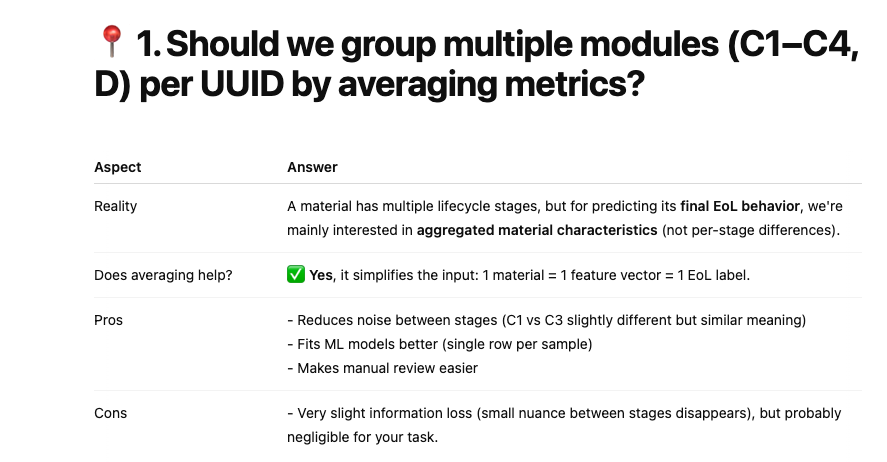

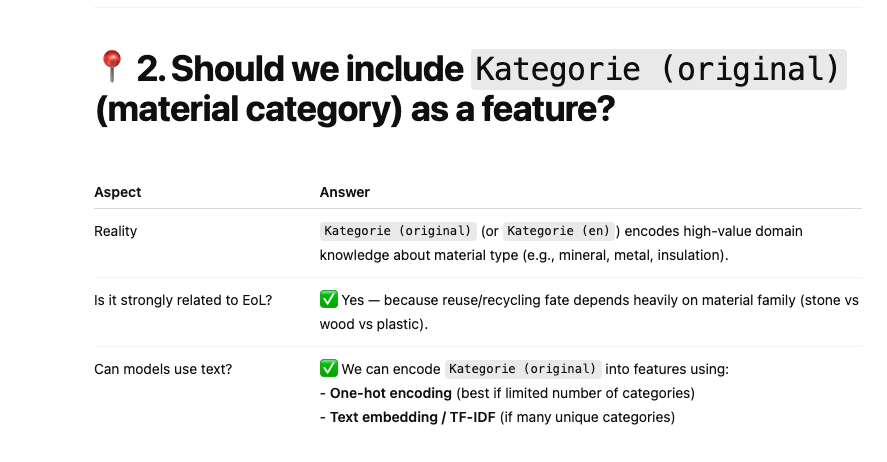

In [31]:
df_multi_module.shape

(18118, 78)

In [32]:
df_eol.shape

(9399, 78)

In [33]:
df_multi_module

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard,oekobaudatProcessUuid,eolCategoryName
0,b6306a21-cb84-4992-bf23-8f4992ab132f,00.00.013,Claytec Mineral 20,Claytec Mineral 20,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,8.308000e-05,3.862000e-11,6.946000e-07,1.999000e-01,1.645000e-03,2024,A2,NaN,NaN
1,b6306a21-cb84-4992-bf23-8f4992ab132f,00.00.013,Claytec Mineral 20,Claytec Mineral 20,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,1.183000e-13,2.406605e-07,7.759395e-09,9.749585e-03,7.493515e-07,2024,A2,NaN,NaN
2,b6306a21-cb84-4992-bf23-8f4992ab132f,00.00.013,Claytec Mineral 20,Claytec Mineral 20,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,4.020000e-14,8.188826e-08,2.640248e-09,3.317439e-03,2.549778e-07,2024,A2,NaN,NaN
3,b6306a21-cb84-4992-bf23-8f4992ab132f,00.00.013,Claytec Mineral 20,Claytec Mineral 20,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,1.997000e-12,2.006811e-06,1.991389e-07,2.780420e-02,4.727165e-05,2024,A2,NaN,NaN
4,bfeb1818-e35e-4579-8f9d-07e0bc80cd81,00.00.049,Claytec Lehmoberputz grob mit Stroh,Claytec Lehmoberputz grob mit Stroh,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,1.997000e-12,2.006811e-06,2.780420e-02,1.991389e-07,4.727165e-05,2024,A2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18113,8d06b1df-e898-4009-adee-57ca44aaafcc,00.05.000,BauderTHERMOFOL,BauderTHERMOFOL U / M,'Kunststoffe' / 'Dachbahnen' / 'PVC-Dachbahnen','Plastics' / 'Roofing membranes' / 'PVC sheet','DIN EN 15804' / 'ISO 14025',DE,average dataset,2016.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1,NaN,NaN
18114,8d06b1df-e898-4009-adee-57ca44aaafcc,00.05.000,BauderTHERMOFOL,BauderTHERMOFOL U / M,'Kunststoffe' / 'Dachbahnen' / 'PVC-Dachbahnen','Plastics' / 'Roofing membranes' / 'PVC sheet','DIN EN 15804' / 'ISO 14025',DE,average dataset,2016.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1,NaN,NaN
18115,acc44187-3de9-462d-b332-4b1806e5897c,00.04.000,Eurolight roh,Eurolight raw lightweight boards,'Holz' / 'Holzwerkstoffe' / 'Spanplatten','Wood' / 'Derived timber products' / 'Particle...,'DIN EN 15804' / 'ISO 14025',EU-27,specific dataset,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1,NaN,NaN
18116,acc44187-3de9-462d-b332-4b1806e5897c,00.04.000,Eurolight roh,Eurolight raw lightweight boards,'Holz' / 'Holzwerkstoffe' / 'Spanplatten','Wood' / 'Derived timber products' / 'Particle...,'DIN EN 15804' / 'ISO 14025',EU-27,specific dataset,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1,NaN,NaN


In [34]:
# groupping environmetlal metrics by UUID

# Step 1: Filter to EoL-relevant modules (C1, C2, C3, C4, D)
# eol_relevant_modules = ["C1", "C2", "C3", "C4", "D"]
# df_eol = df_multi_module[df_multi_module["Modul"].isin(eol_relevant_modules)].copy()
# df_eol = df_eol.dropna(subset=["UUID"])

df_eol = df_multi_module.copy()


# Step 2: Define environmental metrics
environmental_metrics = [
    "SM", "CRU", "MFR", "MER", "FW",
    "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)",
    "AP (A2)", "POCP (A2)", "ADPF (A2)", "ADPE (A2)", "WDP (A2)",
    "EPmarine (A2)", "EPfreshwater (A2)", "EPterrestrial (A2)",
    "ODP (A2)"
]

# Step 3: Group by UUID and average metrics across modules
df_env_grouped = df_eol.groupby("UUID")[environmental_metrics].mean()

# Step 4: Bring in material category features again
category_keywords = {
    "is_brick": ["brick", "Fired brick"],
    "is_concrete": ["concrete", "precast concrete"],
    "is_insulation": ["insulation", "thermal insulation"],
    "is_metal": ["metal", "steel", "aluminum"],
    "is_wood": ["wood", "timber"],
    "is_stone": ["stone", "natural stone", "slate"],
    "is_roofing": ["roof", "roof tiles"],
    "is_plaster": ["plaster", "gypsum"],
    "is_flooring": ["flooring", "floor panels"],
    "is_fibre": ["fiber", "fibers", "fibre cement"]
}

def create_binary_feature(text, keywords):
    if pd.isnull(text):
        return 0
    text_lower = text.lower()
    return int(any(kw.lower() in text_lower for kw in keywords))

for feature, keywords in category_keywords.items():
    df_multi_module[feature] = df_multi_module["Kategorie (en)"].apply(lambda x: create_binary_feature(x, keywords))

# Material features per UUID (take max, since binary 0/1)
material_features = list(category_keywords.keys())
df_mat_grouped = df_multi_module.groupby("UUID")[material_features].max()

# Merge environmental + material category features
df_combined = pd.concat([df_env_grouped, df_mat_grouped], axis=1)



df_combined.shape


(2619, 27)

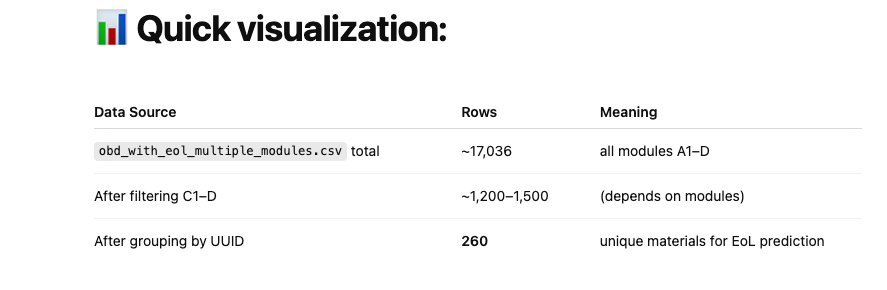

🧠 Why so little values?
You have many UUIDs in Ökobaudat.

But when we created the final feature table (df_combined_encoded), it only included UUIDs that had C1–C4, D module data available (and no missing values after feature engineering).

Some UUIDs don't have enough environmental metrics to even generate features.

✅ So the set of "truly predictable" unlabeled UUIDs is smaller than the whole unmatched UUID pool.



In [35]:
df_combined

,SM,CRU,MFR,MER,FW,GWPtotal (A2),GWPbiogenic (A2),GWPfossil (A2),AP (A2),POCP (A2),...,is_brick,is_concrete,is_insulation,is_metal,is_wood,is_stone,is_roofing,is_plaster,is_flooring,is_fibre
UUID,,,,,,,,,,,,,,,,,,,,,
00485255-d8a7-4e6d-b2ab-fba929e3cc4a,121.000000,0.0,0.000000,0.000000,0.200000,493.000000,0.290000,493.000000,0.833000,0.782000,...,0,0,0,0,0,0,0,0,0,0
004f3f4e-5bb8-4d9e-a104-6999a9e8ad5b,0.000000,0.0,0.000000,0.000000,0.107282,52.964857,0.193591,52.652082,0.098622,0.092750,...,0,1,0,0,0,0,0,1,0,0
006c17a5-bfbd-4786-8c96-7546e5317f9c,0.095625,0.0,0.000000,0.000000,0.002904,0.189175,0.014410,0.174682,0.001261,0.000437,...,0,0,1,0,0,0,0,0,0,0
007312d2-a91b-48fd-b037-f4632e49b366,0.000000,0.0,0.000000,0.000000,0.000614,0.157030,0.001769,0.155232,0.000230,0.000170,...,0,0,0,0,0,0,0,0,0,0
0076d763-304a-4d3c-8773-e767c8a56cf9,0.122376,0.0,0.000000,0.125714,0.000817,0.167731,0.098503,0.069159,0.000137,0.000132,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9336ea-fb7f-4299-8a40-5e9a28538c85,0.000000,0.0,0.000000,0.000000,0.003379,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
ffc50051-b4fd-4937-86f2-14ddf568f2ef,0.791000,0.0,0.336000,0.009667,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
ffd4bc0e-1d99-4e84-8710-6dcbf34a98a6,0.000000,0.0,0.048500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0


## feature engineering

In [36]:
# Step 2: Feature engineering from "Kategorie (original)"

# 1. Extract the most recent "Kategorie (original)" per UUID
# We'll use the most common (mode) "Kategorie (original)" per material (UUID)
kategorie_per_uuid = df_multi_module.groupby("UUID")["Kategorie (original)"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# 2. Merge into our previously grouped environmental-material dataset
df_combined["Kategorie (original)"] = df_combined.index.map(kategorie_per_uuid)

# 3. One-hot encode "Kategorie (original)"
df_combined_encoded = pd.get_dummies(df_combined, columns=["Kategorie (original)"], dummy_na=False)

df_combined_encoded.shape


(2619, 290)

One-hot encoded Kategorie (original) and merged it into  training dataset

Current Status:
260 unique materials (UUIDs)

156 features total:

17 environmental impact indicators (averaged over modules C1–D)

10 engineered material type features (is_brick, is_concrete, etc.)

~129 one-hot columns representing material categories (Kategorie (original))

Why this is powerful:
Now the model knows both quantitative environmental properties and qualitative material types.

Many EoL outcomes are tightly linked to material type — this should boost accuracy significantly.

## trying again including all modules


In [37]:
# Re-import libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Load the uploaded dataset


# Step 1: Focus only on environmental metrics (no material keywords for now)
environmental_metrics = [
    "SM", "CRU", "MFR", "MER", "FW",
    "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)",
    "AP (A2)", "POCP (A2)", "ADPF (A2)", "ADPE (A2)", "WDP (A2)",
    "EPmarine (A2)", "EPfreshwater (A2)", "EPterrestrial (A2)",
    "ODP (A2)"
]

# Step 2: Group all modules (A1–D) by UUID
df_all_modules = df_multi_module.dropna(subset=["UUID"]).copy()

# Average environmental metrics across all available modules
df_env_grouped_all = df_all_modules.groupby("UUID")[environmental_metrics].mean()

# Step 3: Impute missing values (median strategy)
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(df_env_grouped_all), 
                         columns=df_env_grouped_all.columns, 
                         index=df_env_grouped_all.index)



X_imputed.shape


(2619, 17)

## → Attach material category (Kategorie (original)) and one-hot encode it



In [38]:
# Step 2: Attach "Kategorie (original)" and one-hot encode it

# 1. Find the most common "Kategorie (original)" per UUID
kategorie_per_uuid = df_multi_module.groupby("UUID")["Kategorie (original)"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# 2. Map it into the X_imputed table
X_imputed["Kategorie (original)"] = X_imputed.index.map(kategorie_per_uuid)

# 3. One-hot encode "Kategorie (original)"
X_imputed_encoded = pd.get_dummies(X_imputed, columns=["Kategorie (original)"], dummy_na=False)

X_imputed_encoded.shape


(2619, 280)

In [39]:
categories_obd_eol = df_multi_module[["Kategorie (en)", "eolCategoryName"]]
categories_obd_eol

,Kategorie (en),eolCategoryName
0,'Mineral building products' / 'Mortar and Conc...,NaN
1,'Mineral building products' / 'Mortar and Conc...,NaN
2,'Mineral building products' / 'Mortar and Conc...,NaN
3,'Mineral building products' / 'Mortar and Conc...,NaN
4,'Mineral building products' / 'Mortar and Conc...,NaN
...,...,...
18113,'Plastics' / 'Roofing membranes' / 'PVC sheet',NaN
18114,'Plastics' / 'Roofing membranes' / 'PVC sheet',NaN
18115,'Wood' / 'Derived timber products' / 'Particle...,NaN
18116,'Wood' / 'Derived timber products' / 'Particle...,NaN


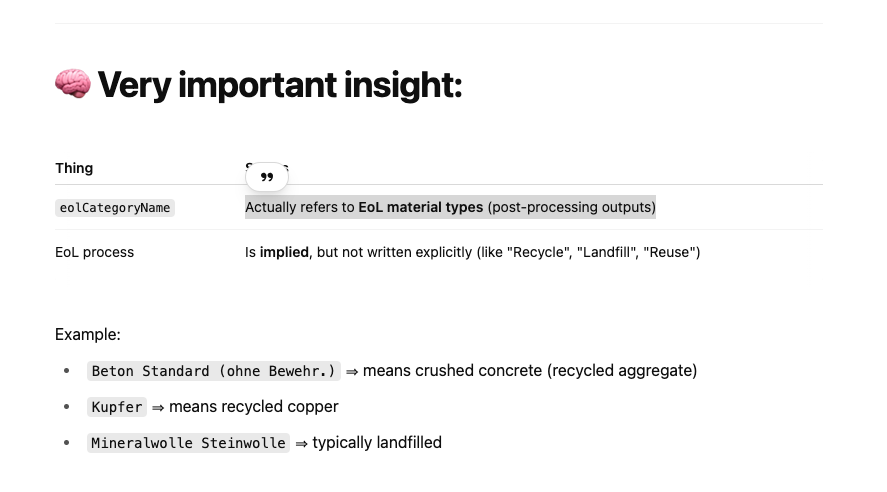

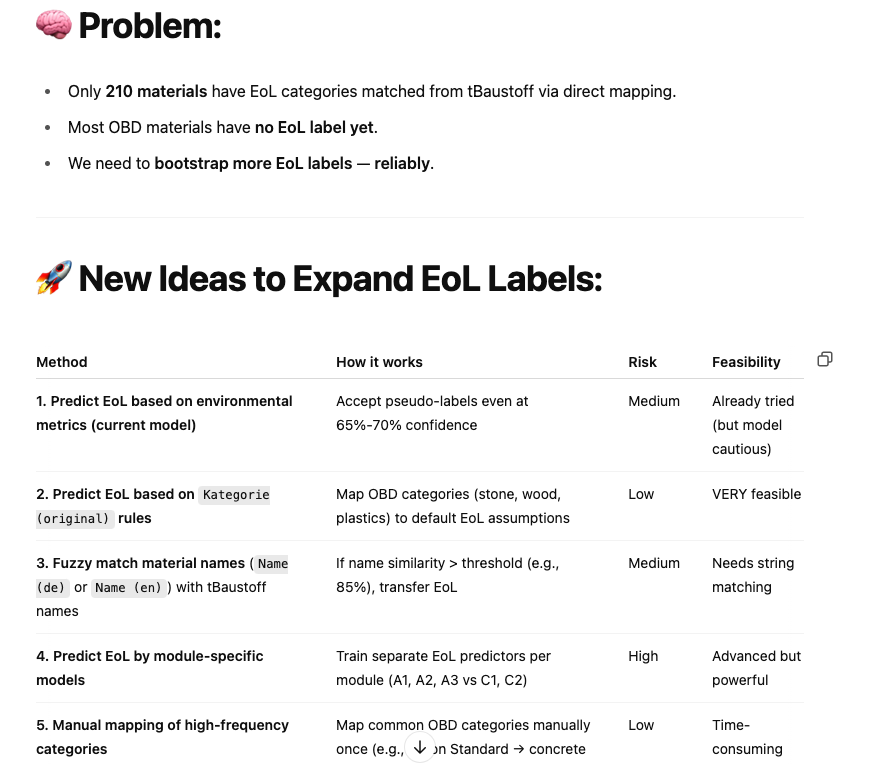

## groupping eolcategory into general classes
Step-by-Step Plan:
Cluster all real eolCategoryName values into about 6–8 General EoL Classes.

Create a mapping dictionary:
eolCategoryName ➔ General EoL Class

Then, when you assign a general EoL label based on Kategorie (original),
you map it to the clustered EoL class, not to 100+ individual types.let

In [40]:
df_multi_module["eolCategoryName"].isnull().sum()

np.int64(17036)

In [41]:
# import materials from components
materials_from_components = pd.read_csv('/Users/pablosoriano/Documents/Data Science/bbsr-challenge/all_uuid_materials_from_components.csv')

# type of connections
To determine the type of connections used between materials—which is critical for predicting pollutants introduced by adhesives, coatings, or jointing compounds—we need to consider indirect indicators from the datasets, as the specific connection method (e.g., glue, screws, nails) isn't explicitly listed. However, several proxy features and strategies can help infer this:

1. Co-occurrence Patterns in Components
From all_uuid_materials_from_components.csv:

Materials that frequently appear together within the same component (e.g., wall or floor system) likely share physical interfaces where connection types (adhesives, mortars, etc.) are applied.

Grouping these co-occurring materials allows for inference of likely pollutant types associated with their assembly.

✅ Approach:
Build a co-occurrence matrix or network graph to detect frequent material combinations. Then correlate these with pollutant combinations in pollutant_labeled_obd_translated.csv.

2. Material Function and Category
From pollutant_labeled_obd_translated.csv (joined with OBD metadata):

Fields like Kategorie (en) and Name (en) or Name (de) can imply material roles:

"Adhesive," "Sealant," "Mortar," "Coating" indicate materials used for bonding or finishing.

These suggest the presence of pollutants like S2 (bitumen, adhesives), S3 (gypsum-based compounds), or S4 (chemical coatings).

✅ Approach:
Train a classifier or rule-based engine using material roles to predict likely joint methods and thus pollutant classes.

3. EOL Scenario and Technology Factor
From tBaustoff_with_OBD_mapping.csv:

eolScenarioUnbuiltReal / Potential and technologyFactor provide info on separability and disassembly potential.

Lower separability likely implies permanent joints (e.g., adhesives), while high separability suggests mechanical connections (screws, clips).

✅ Approach:
Use EOL scenarios as a feature in a model to infer connection difficulty—and associated pollutant likelihood (e.g., glue residues in S2/S3).



Summary
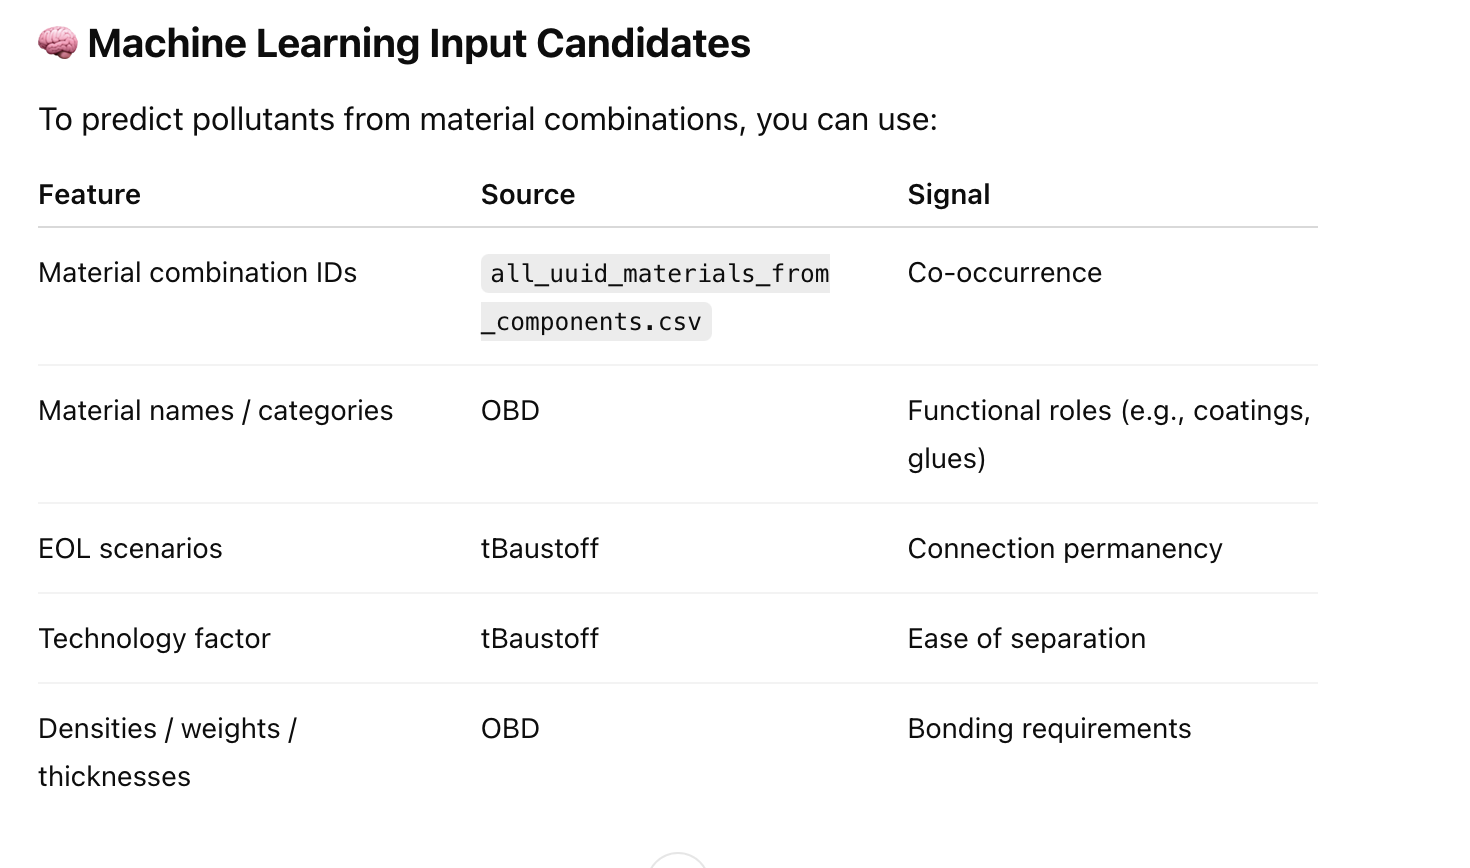

## co occurence matrix

In [42]:
materials_from_components.head() 

,t_value,material_name,thickness_mm,database,life_cycle,process,uuid,subcomponent_id,main_component_id,main_component_name,subcomponent_name
0,246,Innenfarbe Dispersionsfarbe scheuerfest,"0,3",Ökobau.dat 2009,Herstellung,Innenfarbe Dispersionsfarbe scheuerfest,fe322638-133c-476b-b7e1-3ef4508e6854,450082,450081.0,Außenwand / einschaliges Mauerwerk / WDVS mit ...,Gips-Putz/Anstrich
1,246,Innenfarbe Dispersionsfarbe scheuerfest,"0,3",Ökobau.dat 2011,Herstellung,Innenfarbe Dispersionsfarbe scheuerfest,345bd098-f17b-4217-9b12-2124222e93e2,450082,450081.0,Außenwand / einschaliges Mauerwerk / WDVS mit ...,Gips-Putz/Anstrich
2,246,Innenfarbe Dispersionsfarbe scheuerfest,"0,3",OeKOBAUDAT_2016-I_A1,A1 - A3 Aggregation,Innenfarbe Dispersionsfarbe scheuerfest,35be6146-5a80-4a9e-a32d-5d05c03a8d5c,450082,450081.0,Außenwand / einschaliges Mauerwerk / WDVS mit ...,Gips-Putz/Anstrich
3,246,Innenfarbe Dispersionsfarbe scheuerfest,"0,3",OBD_2020_II_A1,A1 - A3 Aggregation,Innenfarbe Dispersionsfarbe scheuerfest,35be6146-5a80-4a9e-a32d-5d05c03a8d5c,450082,450081.0,Außenwand / einschaliges Mauerwerk / WDVS mit ...,Gips-Putz/Anstrich
4,246,Innenfarbe Dispersionsfarbe scheuerfest,"0,3",OBD_2021_II_A1,A1 - A3 Aggregation,Innenfarbe Dispersionsfarbe scheuerfest,35be6146-5a80-4a9e-a32d-5d05c03a8d5c,450082,450081.0,Außenwand / einschaliges Mauerwerk / WDVS mit ...,Gips-Putz/Anstrich


when we scraped the elca web app, the materials for each component where repeated many times depending on the database version
We will remove materials that are repeated in the same subcomponent id, keeping only the latest version.

In [43]:
# dealing with duplicates by uuid and subcomponent_id
materials_sorted.sort_values(by="database", ascending=False, inplace=True)
materials_sorted.drop_duplicates(subset=["uuid", "subcomponent_id"], keep="first", inplace=True)

In [44]:
materials_sorted

,t_value,thickness_mm,database,life_cycle,process,uuid,subcomponent_id,main_component_id,main_component_name,subcomponent_name
130,246,100,OBD_2024_A2,A1 - A3 Aggregation,Konstruktionsvollholz (Durchschnitt DE),7aba3603-0689-4da5-8d24-fd92ae398d07,450090,450088.0,Außenwand / Holzrahmenbau / Holzverkleidung,IBO_AW_01
2507,269,2,OBD_2024_A2,A1 - A3 Aggregation,Dachbahnen EPDM,498cd894-8ae6-458c-b874-9022cb148409,556590,556587.0,Flachdach unbelüftet / Holzrahmenbau,Holzrahmen belüftet - Blech
2448,269,50,OBD_2024_A2,A1 - A3 Aggregation,"Stahl Feinblech (0,3-3,0mm)",89318772-3a50-4f56-9839-d0a8c702e396,556588,556587.0,Flachdach unbelüftet / Holzrahmenbau,Gipskarton abgehangen
2658,269,50,OBD_2024_A2,A1 - A3 Aggregation,"Stahl Feinblech (0,3-3,0mm)",89318772-3a50-4f56-9839-d0a8c702e396,558578,558577.0,Gründach extensiv / Holzmassivbau,Gipskarton abgehangen
680,256,75,OBD_2024_A2,A1 - A3 Aggregation,Mineralwolle (Innenausbau-Dämmung),a5b22bbe-175d-4aef-bb19-4954e699eb8c,194817,194927.0,Innenwand / Gipskarton / doppelbeplankt,Metallständer_75mm mit Dämmung
...,...,...,...,...,...,...,...,...,...,...
815,256,"12,5",OBD_2009_,Herstellung,Gipskartonplatte (imprägniert),76c06eb8-5318-4363-9143-36cc3e25286b,450135,450134.0,Innenwand / Gipskarton / doppelbeplankt,"GK_12,5mm_doppelt_beplankt_Anstrich_gespachtelt"
1835,264,160,OBD_2009_,Herstellung,Splitt 2/15 (getrocknet),dc68e5bb-5277-4b3b-846e-2a4d10fee83b,4644669,4644667.0,Hohlkastendecke / Konstruktionsvollholz / Spli...,Holzkasten mit Schüttung
761,256,"12,5",OBD_2009_,Herstellung,Gipskartonplatte (imprägniert),76c06eb8-5318-4363-9143-36cc3e25286b,450127,450126.0,Innenwand / Gipskarton / doppelbeplankt,"GK_12,5mm_doppelt_beplankt_Anstrich_gespachtelt"
153,246,"12,5",OBD_2009_,Herstellung,Gipskartonplatte (imprägniert),76c06eb8-5318-4363-9143-36cc3e25286b,450093,450092.0,Außenwand Gaube / Holzrahmenbau / Schieferverk...,"Gipskartonplatte_12,5mm_Kleber_g"


In [45]:
# to csv
materials_sorted.to_csv("materials_sorted.csv", index=False)

In [46]:
# unique materials (processes)
materials_sorted["uuid"].nunique()

264

In [47]:
materials_sorted["process"].nunique()

91

## Step 1: co occurrence matrix

🔄 Processing Steps (Confirmed)
Group materials by main_component_id.

For each group (i.e., component), compute all unique unordered pairs of UUIDs.

Count how often each pair co-occurs across components.

Convert this into a symmetric matrix (UUID × UUID) where each cell contains the number of co-occurrences.

In [48]:
from itertools import combinations
import numpy as np
from collections import Counter

# Group UUIDs by main_component_id
grouped = materials_sorted.groupby("main_component_id")["process"].apply(list)

# Count co-occurrences
co_occurrence_counter = Counter()
for uuids in grouped:
    # Get all unique unordered pairs from the set of UUIDs in each component
    for a, b in combinations(sorted(set(uuids)), 2):
        co_occurrence_counter[(a, b)] += 1

# Create a list of unique UUIDs
unique_uuids = sorted(materials_sorted["process"].unique())
uuid_index = {uuid: idx for idx, uuid in enumerate(unique_uuids)}

# Initialize a square matrix with zeros
matrix = np.zeros((len(unique_uuids), len(unique_uuids)), dtype=int)

# Fill the matrix with co-occurrence counts
for (a, b), count in co_occurrence_counter.items():
    i, j = uuid_index[a], uuid_index[b]
    matrix[i, j] = count
    matrix[j, i] = count  # Symmetric

# Convert to DataFrame for easier viewing
co_occurrence_df = pd.DataFrame(matrix, index=unique_uuids, columns=unique_uuids)



In [49]:
grouped

main_component_id
1845.0       [Transportbeton C20/25, Mineralwolle (Boden-Dä...
5022.0       [Innenfarbe Dispersionsfarbe scheuerfest, Inne...
11250.0      [Dampfbremse PE, Transportbeton C25/30, Dampfb...
11253.0      [Mineralwolle (Innenausbau-Dämmung), PE/PP Vli...
11256.0      [Bitumenbahnen PYE PV 200 S5 (ungeschiefert), ...
11280.0      [PE/PP Vlies, Bewehrungsstahl, Bewehrungsstahl...
11281.0      [Gipsputz (Gips), Gipsputz (Gips), Kalksandste...
11293.0      [Dachziegel, PE/PP Vlies, Dampfbremse PE, Mine...
11296.0      [Dampfbremse PET gitterverstärkt, Polyethylen-...
194128.0     [Mineralwolle (Innenausbau-Dämmung), Innenfarb...
194927.0     [Mineralwolle (Innenausbau-Dämmung), Innenfarb...
194931.0     [Mineralwolle (Innenausbau-Dämmung), Innenfarb...
450081.0     [Isolierglas 2-Scheiben, Armierung (Kunstharzs...
450088.0     [Konstruktionsvollholz (Durchschnitt DE), Mine...
450092.0     [Mineralwolle (Fassaden-Dämmung), Konstruktion...
450096.0     [Fassadenfarbe Silikat-D

In [50]:
co_occurrence_df

,3- und 5-Schicht Massivholzplatte (Durchschnitt DE),Armierung (Kunstharzspachtel),Beton der Druckfestigkeitsklasse C 25/30,Bewehrungsstahl,"Bitumen Emulsion (40% Bitumen, 60% Wasser)","Bitumen Kaltkleber (60% Bitumen, 23%LM, 17% Wasser)",Bitumenbahnen PYE PV 200 S5 (ungeschiefert),"Bitumenbahnen PYE PV 200 S5 (ungeschiefert) (Dicke 0,004 m)",Brettschichtholz - Standardformen (Durchschnitt DE),Brettsperrholz (Durchschnitt DE),...,Transportbeton C25/30,Transportbeton C30/37,Unterspannbahn PP,"Unterspannbahn PP (Dicke 0,00015 m)",Vormauerziegel,XPS-Dämmstoff,Zellulosefaserplatten,Zementestrich,Zementestrich - IWM,eLCA Luftschicht (gemäß EN 15804+A1)
3- und 5-Schicht Massivholzplatte (Durchschnitt DE),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
Armierung (Kunstharzspachtel),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Beton der Druckfestigkeitsklasse C 25/30,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bewehrungsstahl,0,0,2,0,0,2,2,2,0,0,...,3,1,0,0,0,3,1,2,3,0
"Bitumen Emulsion (40% Bitumen, 60% Wasser)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XPS-Dämmstoff,0,0,0,3,0,0,2,2,0,0,...,1,1,0,0,0,0,0,0,0,0
Zellulosefaserplatten,0,0,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,5
Zementestrich,1,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,3
Zementestrich - IWM,0,0,0,3,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


Are these specific or general materials? When changed from uuid to the actual material name (process) it went from 270 to 90 unique processes. 
I will check for materials that appear in many matches. This can give me an idea of materials that work as connectors


In [51]:
# count of matches per material



## heatmap
heatmap showing the co-occurrence frequencies among the top 25 most frequently paired material UUIDs. Each value represents how many building components contained both materials together.

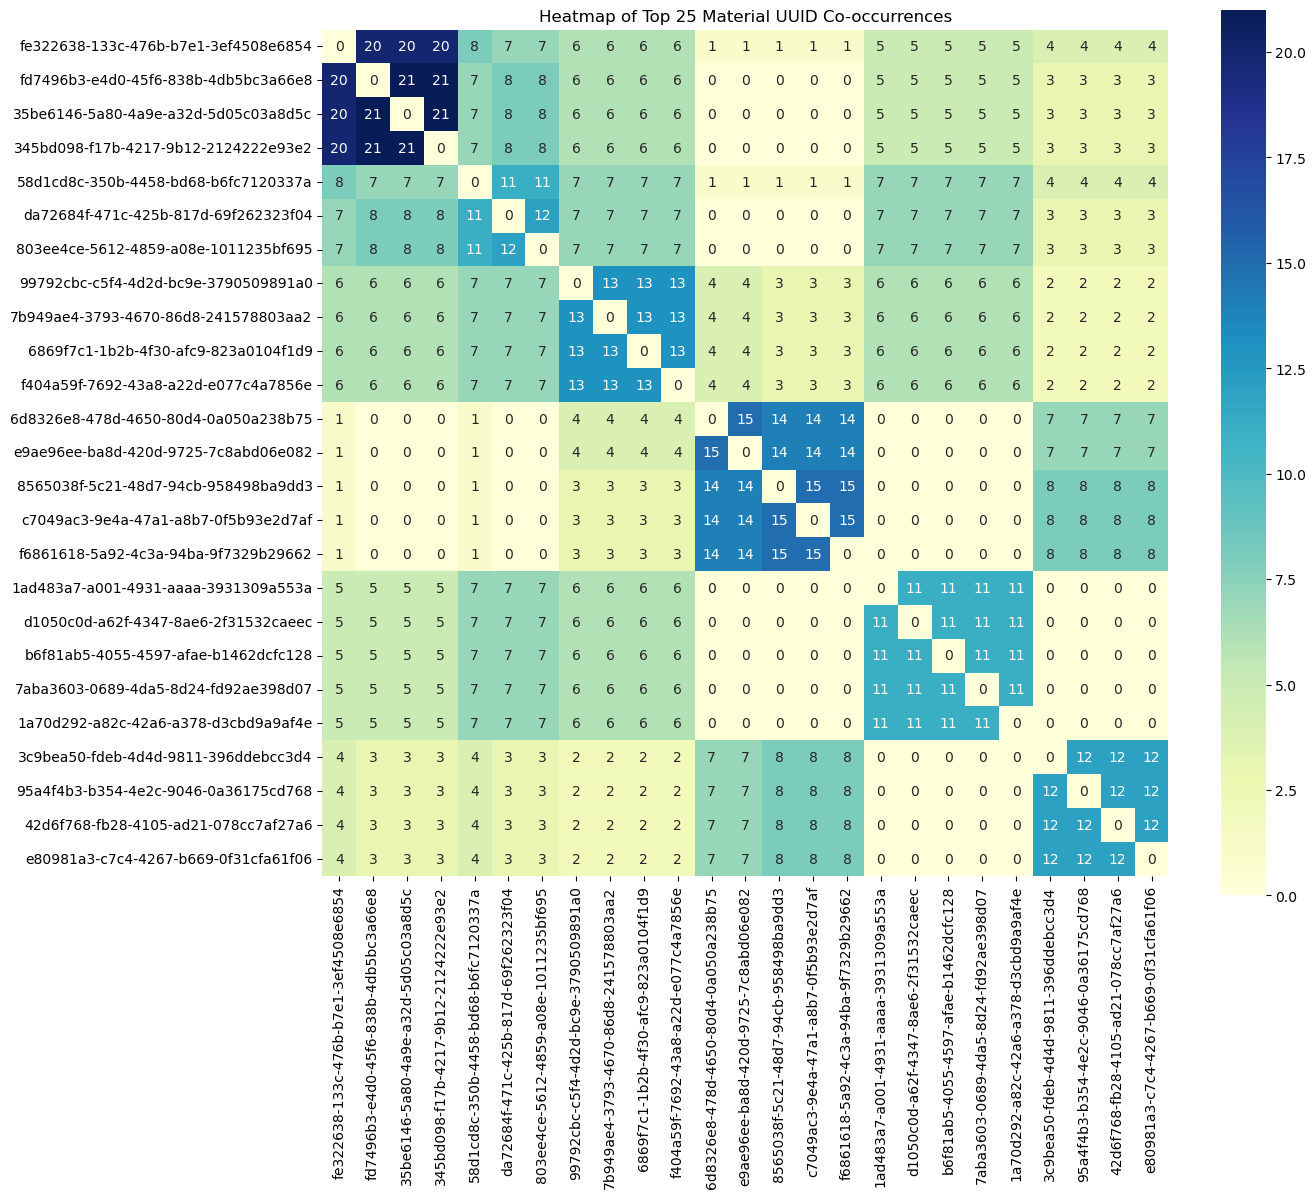

In [52]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Group UUIDs by main_component_id
grouped = materials_sorted.groupby("main_component_id")["uuid"].apply(list)

# Count co-occurrences
co_occurrence_counter = Counter()
for uuids in grouped:
    for a, b in combinations(sorted(set(uuids)), 2):
        co_occurrence_counter[(a, b)] += 1

# Create a list of unique UUIDs
unique_uuids = sorted(materials_sorted["uuid"].unique())
uuid_index = {uuid: idx for idx, uuid in enumerate(unique_uuids)}

# Initialize a square matrix with zeros
matrix = np.zeros((len(unique_uuids), len(unique_uuids)), dtype=int)

# Fill the matrix
for (a, b), count in co_occurrence_counter.items():
    i, j = uuid_index[a], uuid_index[b]
    matrix[i, j] = count
    matrix[j, i] = count

# Convert to DataFrame
co_occurrence_df = pd.DataFrame(matrix, index=unique_uuids, columns=unique_uuids)

# Select top 25 UUIDs by total co-occurrence
uuid_total_counts = co_occurrence_df.sum(axis=1)
top_uuids = uuid_total_counts.sort_values(ascending=False).head(25).index
subset_matrix = co_occurrence_df.loc[top_uuids, top_uuids]

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(subset_matrix, cmap="YlGnBu", annot=True, fmt="d", cbar=True, square=True)
plt.title("Heatmap of Top 25 Material UUID Co-occurrences")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Step 2:  Joining co-occurrence data with pollutant labels.
To understand which pollutants commonly occur in combinations of materials, we’ll enrich the co-occurrence matrix by linking UUIDs to their known pollutant profiles from pollutant_labeled_obd_translated.csv.


 Processing Plan:
1) Load pollutant_labeled_obd_translated.csv:

    - Focus on columns:

        - uuid (material identifier)

        - Fremd-/Störstoffbeschreibung (list of pollutant descriptions)

        - Störstoffklasse (S0–S4 classification)

2) Preprocess pollutants:

    - Convert the Fremd-/Störstoffbeschreibung (pollutant descriptions) to a list of tokens (if comma-separated or similar).

    - Map each uuid to:

        - A set of pollutant tokens

        - A class label (S0–S4)

3) Merge with co-occurrence matrix:

    - For each UUID in the matrix, annotate it with its pollutant class or list.

    - Eventually this will let us compute:

        - What pollutant classes tend to co-occur in material combinations.

        - Which pollutants are dominant in high-frequency combinations.

## Tokenize the pollutant descriptions into lists for easier matching later

In [53]:
# Select relevant columns and drop rows with missing UUIDs
pollutants = obd_with_pollutants[["UUID", "Fremd-/Störstoffbeschreibung", "Störstoffklasse"]].dropna(subset=["UUID"])

# Clean and split pollutant descriptions into lists (if not null)
pollutants["pollutants_list"] = pollutants["Fremd-/Störstoffbeschreibung"].fillna("").apply(
    lambda x: [p.strip().lower() for p in x.split(",") if p.strip()]
)

# Preview cleaned dataset
pollutants[["UUID", "pollutants_list", "Störstoffklasse"]].head()


,UUID,pollutants_list,Störstoffklasse
0,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,[ohne fremd-/störstoffe],S0
1,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,[ohne fremd-/störstoffe],S0
2,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,[ohne fremd-/störstoffe],S0
3,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,[ohne fremd-/störstoffe],S0
4,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,[ohne fremd-/störstoffe],S0


In [54]:
# Prepare for join: rename UUID column to match co-occurrence matrix index/column naming
pollutants = pollutants.rename(columns={"UUID": "uuid"})

# Ensure UUIDs in co-occurrence matrix match those in the pollutant data
uuids_in_both = list(set(co_occurrence_df.index).intersection(set(pollutants["uuid"])))

# Filter co-occurrence matrix to UUIDs that have pollutant labels
filtered_matrix = co_occurrence_df.loc[uuids_in_both, uuids_in_both]

# Filter pollutant data to only those UUIDs
filtered_pollutants = pollutants[pollutants["uuid"].isin(uuids_in_both)].drop_duplicates("uuid")

# Merge metadata into co-occurrence matrix rows (just to annotate, columns remain untouched for now)
annotated_matrix = filtered_matrix.copy()
annotated_matrix.index.name = "uuid"
annotated_matrix = annotated_matrix.merge(
    filtered_pollutants[["uuid", "pollutants_list", "Störstoffklasse"]],
    how="left",
    left_index=True,
    right_on="uuid"
)




In [55]:
annotated_matrix

,592ffe6e-4c21-4a24-ba67-273acbfca373,6869f7c1-1b2b-4f30-afc9-823a0104f1d9,ed734c48-a58f-4f92-a9f7-57631b500fdc,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,ed391263-0e6d-43dd-ad3e-43607545f281,28a26228-4acd-4bba-b62c-54a54c35526f,3abc810c-ef3a-4ab4-b6d8-0217716e213e,498cd894-8ae6-458c-b874-9022cb148409,52ac8701-d612-4cc9-8037-b2dc2a293a8c,50d421e2-3a7b-4659-92a4-f20d6a52fcf0,...,f6861618-5a92-4c3a-94ba-9f7329b29662,08dd6b43-d77b-48fe-8c97-c68294ed4f75,8f6daa87-b2ee-4eb0-95e0-737ac8c6a59f,5541250a-f8d8-4c67-9f24-47ab54686c30,42d6f768-fb28-4105-ad21-078cc7af27a6,3f764d2e-320b-4996-8c28-0f38e8971044,a5b22bbe-175d-4aef-bb19-4954e699eb8c,uuid,pollutants_list,Störstoffklasse
165,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,592ffe6e-4c21-4a24-ba67-273acbfca373,[ohne fremd-/störstoffe],S0
833,2,0,0,5,2,0,1,0,0,0,...,3,1,2,0,2,3,1,6869f7c1-1b2b-4f30-afc9-823a0104f1d9,[ohne fremd-/störstoffe],S0
865,0,0,0,0,0,0,0,0,0,1,...,2,0,0,0,0,0,1,ed734c48-a58f-4f92-a9f7-57631b500fdc,[ohne fremd-/störstoffe],S0
296,0,5,0,0,2,0,0,0,0,0,...,2,1,2,0,1,1,2,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,[ohne fremd-/störstoffe],S0
598,0,2,0,2,0,0,1,0,0,0,...,7,0,0,0,5,0,2,ed391263-0e6d-43dd-ad3e-43607545f281,[ohne fremd-/störstoffe],S0
801,0,0,0,0,0,0,0,0,2,0,...,2,0,0,0,0,0,0,28a26228-4acd-4bba-b62c-54a54c35526f,[ohne fremd-/störstoffe],S0
293,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,3abc810c-ef3a-4ab4-b6d8-0217716e213e,[ohne fremd-/störstoffe],S0
602,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,2,2,0,498cd894-8ae6-458c-b874-9022cb148409,[ohne fremd-/störstoffe],S0
405,0,0,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,52ac8701-d612-4cc9-8037-b2dc2a293a8c,[ohne fremd-/störstoffe],S0
308,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,2,50d421e2-3a7b-4659-92a4-f20d6a52fcf0,[ohne fremd-/störstoffe],S0


What We Just Did
We had a co-occurrence matrix of materials by their uuid, showing how many times each pair appeared together in the same building component.

We also had pollutant labels for materials from the pollutant_labeled_obd_translated.csv file:

Each uuid had a list of pollutants (like "klebereste, gipskarton") and a class label (like "S3").

We matched the two:

For each uuid (row) in the co-occurrence matrix, we attached its:

pollutants_list (tokenized pollutant description)

Störstoffklasse (S0–S4 pollutant class)

The result is an annotated matrix:

It still shows how often materials co-occur (same values as before),

But each row is now labeled with the pollutant profile of that material.

This sets us up for analysis like:

Do materials labeled as S2 often co-occur with S3 materials?

Are klebereste and bitumenreste commonly found in the same components?

#NOTE - Out of 264 unique UUIDs in the co-occurrence matrix:

Only 22 UUIDs were matched to entries in the pollutant-labeled dataset.

That’s roughly 8.3% coverage.

This is quite low, likely because the pollutant_labeled_obd_translated.csv only contains ~1000 labeled materials, and we’re working with a much broader component dataset.

#TODO - can try keeping all versions of databases to see if i get more matches
Maybe i need to match first and then remove duplicates, and not the other way round

# New approach

Look at pollutants and identify material connections. 
I will not try to predict an exact pollutant, but the likely pollutants associated to a given connection.
So first we determine connection type, and then we can suggest pollutants based on these.

Steps: 

1) Find a way to extract material connections from pollutants column
2) Associate connection types to tbaustoff materials
3) 

# type of connections
To determine the type of connections used between materials—which is critical for predicting pollutants introduced by adhesives, coatings, or jointing compounds—we need to consider indirect indicators from the datasets, as the specific connection method (e.g., glue, screws, nails) isn't explicitly listed. However, several proxy features and strategies can help infer this:

1. Co-occurrence Patterns in Components
From all_uuid_materials_from_components.csv:

Materials that frequently appear together within the same component (e.g., wall or floor system) likely share physical interfaces where connection types (adhesives, mortars, etc.) are applied.

Grouping these co-occurring materials allows for inference of likely pollutant types associated with their assembly.

✅ Approach:
Build a co-occurrence matrix or network graph to detect frequent material combinations. Then correlate these with pollutant combinations in pollutant_labeled_obd_translated.csv.

2. Material Function and Category
From pollutant_labeled_obd_translated.csv (joined with OBD metadata):

Fields like Kategorie (en) and Name (en) or Name (de) can imply material roles:

"Adhesive," "Sealant," "Mortar," "Coating" indicate materials used for bonding or finishing.

These suggest the presence of pollutants like S2 (bitumen, adhesives), S3 (gypsum-based compounds), or S4 (chemical coatings).

✅ Approach:
Train a classifier or rule-based engine using material roles to predict likely joint methods and thus pollutant classes.

3. EOL Scenario and Technology Factor
From tBaustoff_with_OBD_mapping.csv:

eolScenarioUnbuiltReal / Potential and technologyFactor provide info on separability and disassembly potential.

Lower separability likely implies permanent joints (e.g., adhesives), while high separability suggests mechanical connections (screws, clips).

✅ Approach:
Use EOL scenarios as a feature in a model to infer connection difficulty—and associated pollutant likelihood (e.g., glue residues in S2/S3).



In [56]:
material_roles_columns = obd_with_pollutants[["Name (de)","Name (en)","UUID", "Kategorie (original)", "Kategorie (en)", "eolCategoryName", "productId","productName", "Fremd-/Störstoffbeschreibung (EN)"]]

In [57]:
material_roles_columns[material_roles_columns["productId"]==2]

,Name (de),Name (en),UUID,Kategorie (original),Kategorie (en),eolCategoryName,productId,productName,Fremd-/Störstoffbeschreibung (EN)
586,Aluminium Profil,Aluminium section,3feca796-791b-46d3-8160-95ef243ffb9d,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles',Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,2,Aluminium Profil,Without foreign/interference substances
587,Aluminium Profil,Aluminium section,3feca796-791b-46d3-8160-95ef243ffb9d,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles',Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,2,Aluminium Profil,coated
590,Aluminiumblech,Aluminium sheet,143a4df2-563e-4ef9-b75b-90e1cf9f7ef9,'Metalle' / 'Aluminium' / 'Aluminiumbleche','Metals' / 'Aluminium' / 'Aluminium sheets',Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,2,Aluminium Profil,Without foreign/interference substances
591,Aluminiumblech,Aluminium sheet,143a4df2-563e-4ef9-b75b-90e1cf9f7ef9,'Metalle' / 'Aluminium' / 'Aluminiumbleche','Metals' / 'Aluminium' / 'Aluminium sheets',Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,2,Aluminium Profil,coated


In [58]:
obd_df = pd.read_csv("csv/obd_merged.csv", sep=";")

/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_2726/3058993595.py:1: DtypeWarning: Columns (13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  obd_df = pd.read_csv("csv/obd_merged.csv", sep=";")


## feature columns
Recommended Features
🏷️ Material Identification
These are critical for text-based modeling (keyword search, TF-IDF, embeddings, etc.):

Name (de) – full German material name (primary text feature)

Name (en) – English translation (secondary text feature)

Kategorie (original) – original category name in German

Kategorie (en) – standardized category name in English



🏗️ End-of-Life and Technology Context
These signal disassembly potential and possible bonding methods:

productName 
eolCategoryName – type of component or use context

eolScenarioUnbuiltReal – real-world EOL treatment (e.g. landfill, mechanical separation)

eolScenarioUnbuiltPotential – best-case EOL scenario

technologyFactor – technical complexity of disassembly (numeric)

🔥 Target Variable
Störstoffklasse (S0–S4): pollutant class (primary target for classification)

Optionally: Fremd-/Störstoffbeschreibung: for multilabel pollutant prediction or string similarity



material identification: all the text-based fields that describe what a material is, usually in terms of its name and category.

These fields are useful because:

They often contain clues about how the material is used (e.g., as an adhesive, board, insulation)

They can be used in rule-based classification, keyword search, or text vectorization (TF-IDF, embeddings) for machine learning

final role distribution using:

Name (de) + Kategorie (original) as primary input

Fallback to productName + eolCategoryName for unmatched entries

## Role Keyword Mapping

In [59]:
# Combine relevant columns
obd_with_pollutants["combined_text"] = (
    obd_with_pollutants["Name (de)"].fillna("") + " " +
    obd_with_pollutants["Kategorie (original)"].fillna("") + " " +
    obd_with_pollutants["productName"].fillna("") + " " +
    obd_with_pollutants["eolCategoryName"].fillna("")
).str.lower()

# role mapping
role_keywords = {
    "adhesive": ["kleber", "klebstoff", "spachtel"],
    "sealant": ["abdichtung", "dicht", "fuge", "bitumen", "bitumenbahn", "epdm", "eva", "ecb",
                "pvc", "dachbahn", "unterspannbahn", "kunststoffbahn", "dampfbremse", "folie", "vlies"],
    "mortar": ["mörtel", "zement", "putz", "verputz", "fugenmörtel", "kalkzementputz", "leichtputz", "ausgleichsmasse",
               "ziegel", "planstein", "leichtbeton", "dachstein", "glasbaustein"],
    "coating": ["farbe", "beschichtung", "lack", "bodenbelag", "linoleum", "korklinoleum", "gussasphaltestrich", "pvc-bodenbelag"],
    "insulation": ["dämm", "wolle", "schaum", "isolierung"],
    "board": ["platte", "gipskarton", "holzfaser"],
    "aggregate": ["kies", "schotter", "sand", "zuschlag", "granulat", "blähton", "naturbims"],
    "metal": ["stahl", "metall", "blech"],
    "wood": ["holz", "sperrholz"]
}
def infer_role(text):
    if pd.isna(text):
        return None
    for role, keywords in role_keywords.items():
        if any(keyword in text for keyword in keywords):
            return role
    return None
# Initial role inference
obd_with_pollutants["material_role"] = obd_with_pollutants["combined_text"].apply(infer_role).fillna("other")

# Refine sealant into subroles
def refine_sealant_role(row):
    if row["material_role"] != "sealant":
        return row["material_role"]
    text = row["combined_text"]
    if any(x in text for x in ["dachbahn", "epdm", "bitumen", "ecb", "eva"]):
        return "roofing_sealant"
    elif any(x in text for x in ["dampfbremse", "vlies", "folie", "unterspannbahn"]):
        return "vapor_barrier"
    elif any(x in text for x in ["pvc", "bodenbelag", "belag"]):
        return "flooring_sealant"
    else:
        return "sealant"
    
 # Apply refinement
obd_with_pollutants["material_role"] = obd_with_pollutants.apply(refine_sealant_role, axis=1)

# # Final role distribution
# role_distribution = obd_with_pollutants["material_role"].value_counts().sort_values(ascending=False)
# role_distribution


In [60]:
# Build multi-label matrix
obd_with_pollutants["target_class"] = obd_with_pollutants["Störstoffklasse"]
context_cols = ["UUID", "material_role", "eolCategoryName", "eolScenarioUnbuiltReal", "eolScenarioUnbuiltPotential", "technologyFactor"]
df_multi = obd_with_pollutants[context_cols + ["target_class"]].dropna().drop_duplicates()
df_multi["value"] = 1
df_pivot = df_multi.pivot_table(index=context_cols, columns="target_class", values="value", fill_value=0).reset_index()

# Train/test split for multi-label classifier
label_cols = [col for col in df_pivot.columns if col.startswith("S")]
X = df_pivot.drop(columns=label_cols + ["UUID"])
y = df_pivot[label_cols]
X_encoded = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
multi_rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
multi_rf.fit(X_train, y_train)

# Predict probabilities
y_proba = multi_rf.predict_proba(X_test)
proba_df = pd.DataFrame({
    class_name: probs[:, 1] for class_name, probs in zip(y.columns, y_proba)
})

# Show first 10 rows of predicted probabilities
proba_df.head(10)


,S0,S1,S2,S3,S4
0,1.000,0.000,0.000,1.000,0.000
1,1.000,0.000,0.000,1.000,0.000
2,0.950,0.000,0.975,0.025,0.005
3,0.815,0.260,0.720,0.950,0.075
4,0.970,0.000,0.235,0.395,0.010
5,0.020,0.015,0.995,0.985,0.005
6,0.985,0.055,0.095,0.305,0.015
7,0.950,0.000,0.975,0.025,0.005
8,0.990,0.005,0.070,0.885,0.005
9,0.930,0.180,0.605,0.360,0.180


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Step 1: Filter relevant columns and drop rows with missing target or features
df_model = obd_with_pollutants[[
    "Störstoffklasse", "material_role", "eolCategoryName", "eolScenarioUnbuiltReal", "eolScenarioUnbuiltPotential", "technologyFactor"
]].dropna()

# Step 2: Split into features and target
X = df_model.drop(columns=["Störstoffklasse"])
y = df_model["Störstoffklasse"]

# Step 3: One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=["material_role", "eolCategoryName", "eolScenarioUnbuiltReal", "eolScenarioUnbuiltPotential"], drop_first=True)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Train multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

report, conf_matrix


/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/env

({'S0': {'precision': 0.4842105263157895,
   'recall': 0.5348837209302325,
   'f1-score': 0.5082872928176796,
   'support': 86.0},
  'S1': {'precision': 1.0,
   'recall': 0.375,
   'f1-score': 0.5454545454545454,
   'support': 16.0},
  'S2': {'precision': 0.18, 'recall': 0.3, 'f1-score': 0.225, 'support': 30.0},
  'S3': {'precision': 0.42857142857142855,
   'recall': 0.35526315789473684,
   'f1-score': 0.38848920863309355,
   'support': 76.0},
  'S4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0},
  'accuracy': 0.411214953271028,
  'macro avg': {'precision': 0.41855639097744357,
   'recall': 0.31302937576499384,
   'f1-score': 0.33344620938106373,
   'support': 214.0},
  'weighted avg': {'precision': 0.44679221418031057,
   'recall': 0.411214953271028,
   'f1-score': 0.4145568213350854,
   'support': 214.0}},
 array([[46,  0, 14, 26,  0],
        [ 0,  6, 10,  0,  0],
        [11,  0,  9, 10,  0],
        [38,  0, 11, 27,  0],
        [ 0,  0,  6,  0,  0]]))

this was single label results
S4 is never correctly predicted
Most predictions fall into S0 and S3, likely due to frequency
S1 is doing better than expected (likely due to distinct kleber-like roles)

## RandomForestClassifier with multi-label wrapper

We will reformat the dataset into multi-label structure (pivot Störstoffklasse into binary columns per class),

In [62]:
# Step 1: Create multi-label one-hot encoded format for each unique row
# We group by the full material context and pivot the target labels

# Add prefix to Störstoffklasse for consistency
# obd_with_pollutants["target_class"] = "S" + obd_with_pollutants["Störstoffklasse"].astype(str)

obd_with_pollutants["target_class"] = obd_with_pollutants["Störstoffklasse"]


# Group by material context and pivot pollutant class into columns
context_cols = ["UUID", "material_role", "eolCategoryName", "eolScenarioUnbuiltReal", "eolScenarioUnbuiltPotential", "technologyFactor"]
df_multi = obd_with_pollutants[context_cols + ["target_class"]].dropna()#.drop_duplicates() #REVIEW - stay or go?
df_multi["value"] = 1
df_pivot = df_multi.pivot_table(index=context_cols, columns="target_class", values="value", fill_value=0).reset_index()



1. Define the unique material context
context_cols = ["UUID", "material_role", "eolCategoryName", "eolScenarioUnbuiltReal", "eolScenarioUnbuiltPotential", "technologyFactor"]

Each material (UUID) can appear in different contexts — combinations of role, end-of-life category, disassembly scenario, and tech factor. These combinations are the features we’ll use to predict pollutants.

2. Select the context and the pollutant class
df_multi = df[context_cols + ["target_class"]].dropna().drop_duplicates()
This keeps only the relevant input features and the single target_class column (e.g., "S0", "S2")
.drop_duplicates() ensures that if the same material-context-pollutant appears twice, it's not double-counted

3. Add a dummy value for pivoting

df_multi["value"] = 1
This is needed so we can pivot the data from:
(UUID, material_role, ..., target_class)
to:
(UUID, material_role, ..., S0=1, S1=0, S2=1, ...)

4. Pivot the pollutant class column into binary columns

df_pivot = df_multi.pivot_table(
    index=context_cols, 
    columns="target_class", 
    values="value", 
    fill_value=0
).reset_index()

This creates one column per Störstoffklasse (S0 to S4), with 1s and 0s indicating whether each class applies to that material-context row.

In [63]:
# Prepare X and y
label_cols = [col for col in df_pivot.columns if col.startswith("S")]
X = df_pivot.drop(columns=label_cols)
y = df_pivot[label_cols]

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=["material_role", "eolCategoryName", "eolScenarioUnbuiltReal", "eolScenarioUnbuiltPotential"], drop_first=True)



In [64]:
label_cols

['S0', 'S1', 'S2', 'S3', 'S4']

In [65]:
# Drop UUID column before training
X_encoded = X_encoded.drop(columns=["UUID"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train multi-label Random Forest
multi_rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
multi_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = multi_rf.predict(X_test)
report_multi = classification_report(y_test, y_pred, target_names=y.columns, output_dict=True)

report_multi


{'S0': {'precision': 0.9444444444444444,
  'recall': 1.0,
  'f1-score': 0.9714285714285714,
  'support': 17.0},
 'S1': {'precision': 1.0,
  'recall': 0.6666666666666666,
  'f1-score': 0.8,
  'support': 3.0},
 'S2': {'precision': 0.9090909090909091,
  'recall': 0.9090909090909091,
  'f1-score': 0.9090909090909091,
  'support': 11.0},
 'S3': {'precision': 1.0,
  'recall': 0.8571428571428571,
  'f1-score': 0.9230769230769231,
  'support': 14.0},
 'S4': {'precision': 1.0,
  'recall': 0.3333333333333333,
  'f1-score': 0.5,
  'support': 3.0},
 'micro avg': {'precision': 0.9545454545454546,
  'recall': 0.875,
  'f1-score': 0.9130434782608695,
  'support': 48.0},
 'macro avg': {'precision': 0.9707070707070706,
  'recall': 0.7532467532467533,
  'f1-score': 0.8207192807192808,
  'support': 48.0},
 'weighted avg': {'precision': 0.9594907407407408,
  'recall': 0.875,
  'f1-score': 0.9028617216117215,
  'support': 48.0},
 'samples avg': {'precision': 0.95,
  'recall': 0.875,
  'f1-score': 0.8983333

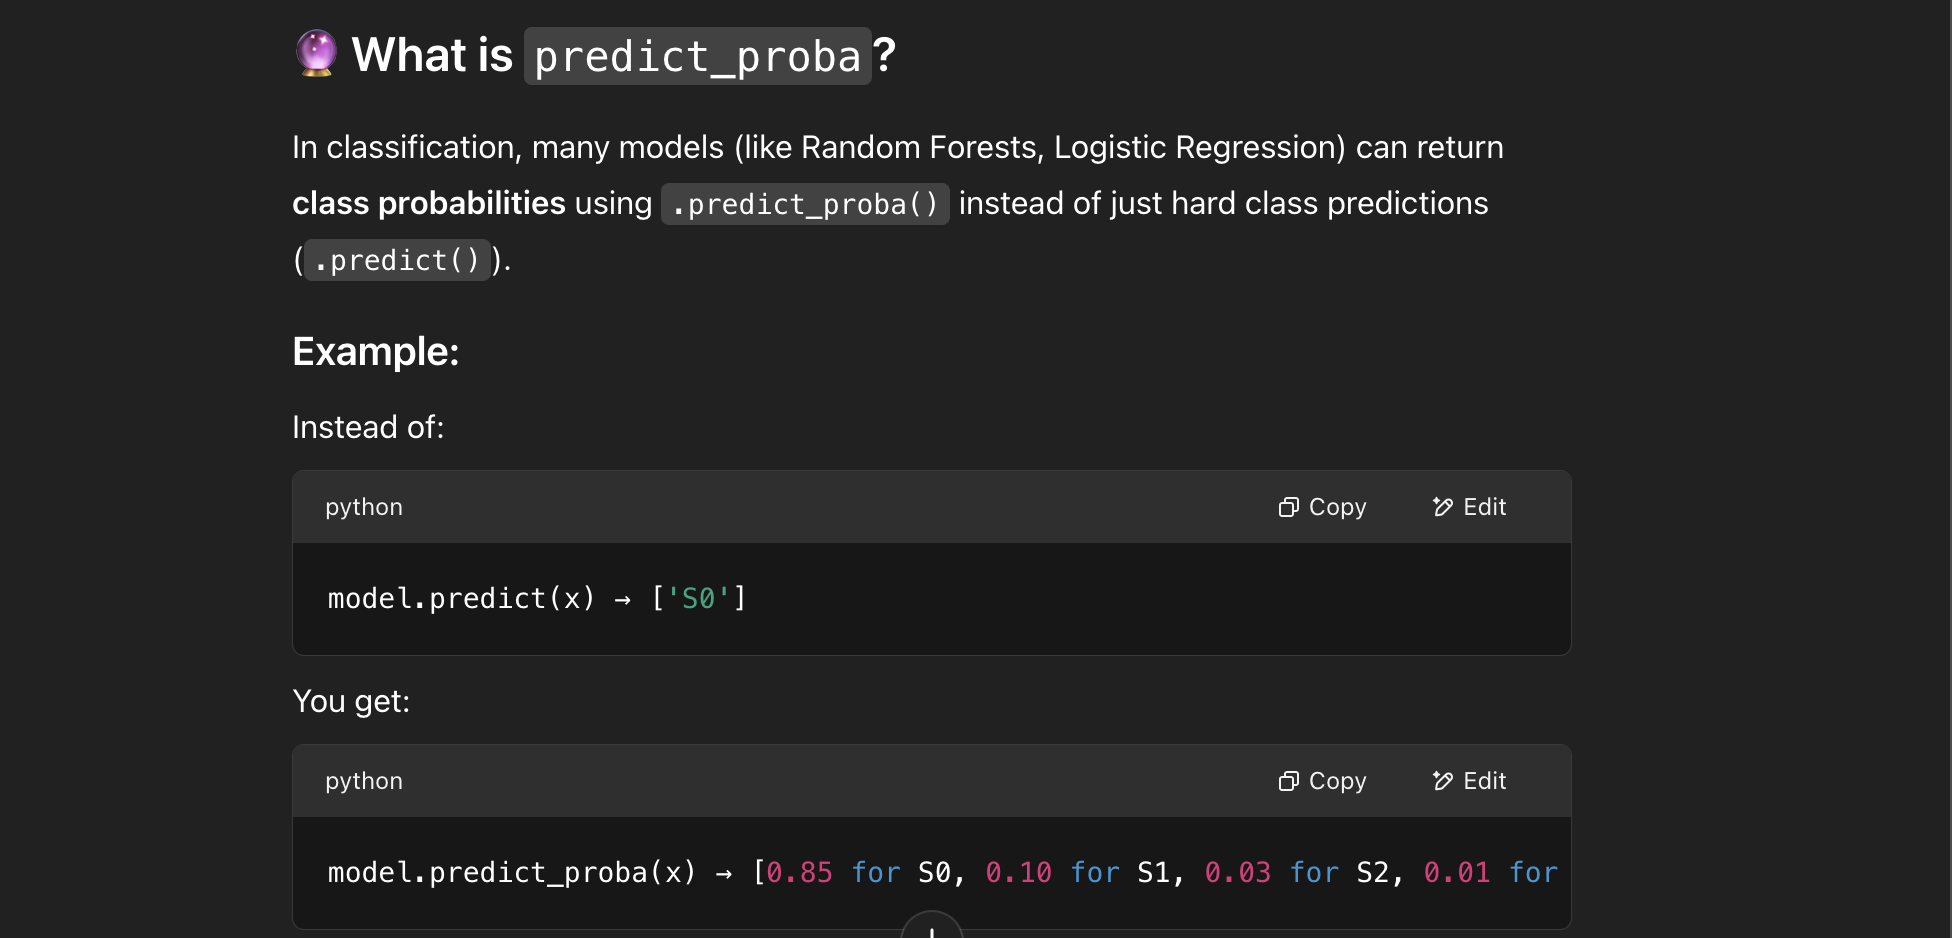

What is threshold tuning?
By default, most classifiers treat:

Any probability ≥ 0.5 as a positive class (i.e. "yes, predict it")

But in multi-label classification, this can be too strict — especially for rare classes like S4.

🔧 Threshold tuning = adjust the cutoff
You can change the threshold per class to optimize for:

Recall (catch more positives, tolerate false alarms)

Precision (avoid false positives)

F1-score (balance the two)

In [66]:
# Predict probabilities
y_proba = multi_rf.predict_proba(X_test)
proba_df = pd.DataFrame({
    class_name: probs[:, 1] for class_name, probs in zip(y.columns, y_proba)
})

# Show first 10 rows of predicted probabilities
proba_df.head(10)


,S0,S1,S2,S3,S4
0,1.000,0.000,0.000,1.000,0.000
1,1.000,0.000,0.000,1.000,0.000
2,0.950,0.000,0.975,0.025,0.005
3,0.815,0.260,0.720,0.950,0.075
4,0.970,0.000,0.235,0.395,0.010
5,0.020,0.015,0.995,0.985,0.005
6,0.985,0.055,0.095,0.305,0.015
7,0.950,0.000,0.975,0.025,0.005
8,0.990,0.005,0.070,0.885,0.005
9,0.930,0.180,0.605,0.360,0.180


Why Probabilities Don’t Add to 1 in Multi-Label

In multi-class classification, where you can only have one class per sample, the class probabilities do add up to 1.
E.g.:

S0: 0.70, S1: 0.10, S2: 0.15, S3: 0.05 → total = 1.00
BUT...

✅ In Multi-Label classification, each class is independent
Each class has its own binary classifier (e.g., "Is this sample S0 or not?"), trained separately.

So the model says:

"I'm 100% confident this material has S0" ✅

"I'm also 100% confident it has S3" ✅

"And 0% for S1, S2, S4"

There’s no constraint that forces them to sum to 1, because multiple labels can be true simultaneously.

📌 In Your Case (Material Pollutants)
That actually makes sense:

A material can contain multiple pollutant classes (e.g., adhesive residues → S1 and bitumen → S3), and we want to detect all of them.

So:

Class	Probability	Meaning
S0	1.00	Very high likelihood (clean or base material)
S3	1.00	Also very likely present (e.g., adhesive or gypsum contaminant)

This matches your data reality, where same UUIDs appear under multiple Störstoffklasse labels.

✅ Summary
Probabilities are per-class (not mutually exclusive)

Multiple classes can be 1.0

Interpret each value as: "Probability this material-context contains this pollutant class"

## Threshholding
thresholding is where you control the trade-off between false positives and false negatives per class

For each pollutant class (S0 to S4), you decide:

✅ "Predict this class if the probability ≥ threshold"

Example for S04

| Threshold | Interpretation                                  |
| --------- | ----------------------------------------------- |
| 0.5       | Conservative — only high confidence predictions |
| 0.3       | Balanced — catch more borderline cases          |
| 0.1       | Aggressive — flag almost anything likely        |

Suggestion

| Class | Typical Role Examples        | Suggestion                                     |
| ----- | ---------------------------- | ---------------------------------------------- |
| S0    | Clean or baseline            | 0.5 (neutral)                                  |
| S1    | Adhesive/Gypsum residues     | 0.3 (common light contaminants)                |
| S2    | Bitumen, heavy adhesives     | 0.3                                            |
| S3    | Gypsum, putz, spachtel       | 0.3                                            |
| S4    | Hazardous (biozide, halogen) | 0.2 (rare but important) ✅ lower to catch more |



In [68]:
# Apply custom thresholds per class to convert probabilities into binary predictions
custom_thresholds = {
    "S0": 0.5,
    "S1": 0.3,
    "S2": 0.3,
    "S3": 0.3,
    "S4": 0.2
}

# Apply thresholds
binary_predictions = pd.DataFrame({
    class_name: (proba_df[class_name] >= threshold).astype(int)
    for class_name, threshold in custom_thresholds.items()
})

# Evaluate the new thresholded predictions
from sklearn.metrics import classification_report

thresholded_report = classification_report(y_test, binary_predictions, target_names=y.columns, output_dict=True)
thresholded_report


{'S0': {'precision': 0.9444444444444444,
  'recall': 1.0,
  'f1-score': 0.9714285714285714,
  'support': 17.0},
 'S1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3.0},
 'S2': {'precision': 0.9090909090909091,
  'recall': 0.9090909090909091,
  'f1-score': 0.9090909090909091,
  'support': 11.0},
 'S3': {'precision': 0.7777777777777778,
  'recall': 1.0,
  'f1-score': 0.875,
  'support': 14.0},
 'S4': {'precision': 0.5,
  'recall': 0.3333333333333333,
  'f1-score': 0.4,
  'support': 3.0},
 'micro avg': {'precision': 0.8653846153846154,
  'recall': 0.9375,
  'f1-score': 0.9,
  'support': 48.0},
 'macro avg': {'precision': 0.8262626262626263,
  'recall': 0.8484848484848484,
  'f1-score': 0.8311038961038962,
  'support': 48.0},
 'weighted avg': {'precision': 0.8634259259259259,
  'recall': 0.9375,
  'f1-score': 0.8950892857142857,
  'support': 48.0},
 'samples avg': {'precision': 0.8833333333333332,
  'recall': 0.9416666666666667,
  'f1-score': 0.9028571428571428,
  'suppor

✅ Multi-Label Metrics with Thresholding

| Class  | Precision | Recall | F1-Score | Notes                                 |
| ------ | --------- | ------ | -------- | ------------------------------------- |
| **S0** | 0.94      | 1.00   | 0.97     | Excellent baseline detection          |
| **S1** | 1.00      | 1.00   | 1.00     | Perfect (due to lower threshold)      |
| **S2** | 0.91      | 0.91   | 0.91     | Very good                             |
| **S3** | 0.78      | 1.00   | 0.88     | Recall-optimized                      |
| **S4** | 0.50      | 0.33   | 0.40     | Better than before — threshold helped |

Averages

| Metric         | Score |
| -------------- | ----- |
| **Micro F1**   | 0.90  |
| **Macro F1**   | 0.83  |
| **Samples F1** | 0.90  |

| Metric     | Optimized For           | Good When…                             |
| ---------- | ----------------------- | -------------------------------------- |
| Micro F1   | Overall performance     | You care about total accuracy          |
| Macro F1   | Fairness across classes | You want rare classes treated equally  |
| Samples F1 | Set-level match per row | You want good predictions per material |

✅ Interpretation

    Getting excellent recall for S0–S3

Even rare S4 is being detected in 33% of its actual cases

F1 scores show you're balancing precision and recall well with your thresholds




## Predicting pollutant clasess for unlabeld materials of Tbaustof

In [69]:
tbs_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/tbs_deduped.csv", sep=";", quotechar='"')


In [71]:
# Reload the file with the correct semicolon separator
tbs_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/tbs_deduped.csv", sep=";", quotechar='"')

# Continue with the feature processing pipeline
tbs_df["combined_text"] = (
    tbs_df["productName"].fillna("") + " " +
    tbs_df["eolCategoryName"].fillna("")
).str.lower()

# Infer role
tbs_df["material_role"] = tbs_df["combined_text"].apply(infer_role).fillna("other")
tbs_df["material_role"] = tbs_df.apply(refine_sealant_role, axis=1)

# Create modeling features
tbs_context = tbs_df[[
    "oekobaudatProcessUuid", "material_role", "eolCategoryName",
    "eolScenarioUnbuiltReal", "eolScenarioUnbuiltPotential", "technologyFactor"
]].drop_duplicates()

# One-hot encode and align with trained model
tbs_encoded = pd.get_dummies(tbs_context.drop(columns=["oekobaudatProcessUuid"]), drop_first=True)
tbs_encoded = tbs_encoded.reindex(columns=X_train.columns, fill_value=0)

# Predict probabilities
tbs_proba = multi_rf.predict_proba(tbs_encoded)
tbs_proba_df = pd.DataFrame({
    class_name: probs[:, 1] for class_name, probs in zip(["S0", "S1", "S2", "S3", "S4"], tbs_proba)
})

# Apply thresholds
tbs_predicted = pd.DataFrame({
    class_name: (tbs_proba_df[class_name] >= threshold).astype(int)
    for class_name, threshold in custom_thresholds.items()
})

# Combine with UUIDs
tbs_results = pd.concat([tbs_context.reset_index(drop=True)[["oekobaudatProcessUuid"]], tbs_predicted], axis=1)


In [72]:
tbs_results

,oekobaudatProcessUuid,S0,S1,S2,S3,S4
0,26353b00-6cd3-426d-903b-9fc5b1670398,1,0,1,0,0
1,5f091578-7d83-46de-bfba-754087398afe,1,0,0,1,1
2,530ff9e2-0189-4783-9546-3bb8f64fbbeb,1,1,1,0,1
3,5541250a-f8d8-4c67-9f24-47ab54686c30,1,0,0,1,0
4,592ffe6e-4c21-4a24-ba67-273acbfca373,1,0,1,0,0
...,...,...,...,...,...,...
307,NaN,1,0,1,1,0
308,NaN,1,0,1,1,0
309,NaN,1,0,1,1,0
310,NaN,1,0,0,1,0


## Looking at product name instead of UUID

In [74]:
# Create modeling features
tbs_context = tbs_df[[
    "productName","oekobaudatProcessUuid", "material_role", "eolCategoryName",
    "eolScenarioUnbuiltReal", "eolScenarioUnbuiltPotential", "technologyFactor"
]].drop_duplicates()

# One-hot encode and align with trained model
tbs_encoded = pd.get_dummies(tbs_context.drop(columns=["productName","oekobaudatProcessUuid"]), drop_first=True)
tbs_encoded = tbs_encoded.reindex(columns=X_train.columns, fill_value=0)

# Predict probabilities
tbs_proba = multi_rf.predict_proba(tbs_encoded)
tbs_proba_df = pd.DataFrame({
    class_name: probs[:, 1] for class_name, probs in zip(["S0", "S1", "S2", "S3", "S4"], tbs_proba)
})

# Apply thresholds
tbs_predicted = pd.DataFrame({
    class_name: (tbs_proba_df[class_name] >= threshold).astype(int)
    for class_name, threshold in custom_thresholds.items()
})

# Combine with UUIDs
tbs_results = pd.concat([tbs_context.reset_index(drop=True)[["productName"]], tbs_predicted], axis=1)


In [ ]:
tbs_results

,productName,SS0,SS1,SS2,SS3,SS4
0,Zinkbleche,1,0,1,0,0
1,CR Profil (Chloropren-Kautschuk),1,0,0,1,1
2,Holz-Blendrahmen,1,1,1,0,1
3,Kunstharzputz,1,0,0,1,0
4,Dachziegel / Ton-,1,0,1,0,0
...,...,...,...,...,...,...
333,Schaumglasgranulat SchÃ¼ttung,1,0,1,1,0
334,SchilfrohrdÃ¤mmmatte,1,0,1,1,0
335,Schilfrohrmatte (PutztrÃ¤ger),1,0,1,1,0
336,"Splitt 2/8, dauerelastisch gebunden (Latex, so...",1,0,0,1,0


## Pollutant Class Probabilities For TBaustoff

In [75]:
tbs_proba_df["productName"] = tbs_context["productName"].values
tbs_proba_df["UUID"] = tbs_context["oekobaudatProcessUuid"].values

# Reorder columns for clarity
columns_ordered = ["productName", "UUID","S0", "S1", "S2", "S3", "S4"]
tbs_proba_df = tbs_proba_df[columns_ordered]


In [76]:
# to csv
tbs_proba_df.to_csv("tbs_proba_df.csv", index=False)
tbs_proba_df


,productName,UUID,S0,S1,S2,S3,S4
0,Zinkbleche,26353b00-6cd3-426d-903b-9fc5b1670398,0.880,0.000,0.950,0.025,0.005
1,CR Profil (Chloropren-Kautschuk),5f091578-7d83-46de-bfba-754087398afe,0.605,0.050,0.285,0.305,0.335
2,Holz-Blendrahmen,530ff9e2-0189-4783-9546-3bb8f64fbbeb,0.945,0.460,0.625,0.260,0.490
3,Kunstharzputz,5541250a-f8d8-4c67-9f24-47ab54686c30,0.985,0.055,0.095,0.305,0.015
4,Dachziegel / Ton-,592ffe6e-4c21-4a24-ba67-273acbfca373,0.920,0.000,0.335,0.275,0.105
...,...,...,...,...,...,...,...
333,Schaumglasgranulat SchÃ¼ttung,NaN,0.900,0.115,0.565,0.370,0.010
334,SchilfrohrdÃ¤mmmatte,NaN,0.860,0.145,0.390,0.615,0.035
335,Schilfrohrmatte (PutztrÃ¤ger),NaN,0.905,0.105,0.435,0.695,0.060
336,"Splitt 2/8, dauerelastisch gebunden (Latex, so...",NaN,0.975,0.140,0.180,0.605,0.015


How to intepret this?

For each oekobaudatProcessUuid, these are independent probabilities:

| UUID      | S0   | S1   | S2   | S3   | S4   |
| --------- | ---- | ---- | ---- | ---- | ---- |
| `2635...` | 0.88 | 0.00 | 0.95 | 0.03 | 0.01 |


This means:

- There's an 88% chance that this material is in class S0
- A 95% chance that it's also in class S2
- A small (but non-zero) chance of S3 or S4

These values are raw probabilities, not yet thresholded — so you can adjust your classification strictness per class.

To turn that probability into a concrete yes/no prediction (i.e., “this material contains S3”), you need to apply a threshold:

| Probability | Threshold | Prediction              |
| ----------- | --------- | ----------------------- |
| 0.87        | ≥ 0.5     | ✅ Yes (predict S3)      |
| 0.87        | ≥ 0.9     | ❌ No (don't predict S3) |

Each class (S0 to S4) can have its own threshold, which controls:

- Recall: Lower threshold → catch more true positives

- Precision: Higher threshold → fewer false positives

Why Use Raw Probabilities?

Having the raw scores means you can choose how strict or lenient to be:

- For rare but important pollutants (like S4), you might accept a lower threshold (e.g. 0.2)

- For baseline categories (like S0), you might use a higher threshold (e.g. 0.5 or 0.6)



# Multi-Label Contaminant Prediction
Instead of:

"Which class (S1–S4) does this material belong to?"

Now ask:

"Which contaminants (e.g. klebereste, biozide) are likely for this material?"

🔄 How to Structure This
Tokenize Fremd-/Störstoffbeschreibung per material row
→ Build a vocabulary of terms (e.g. top 100–200 most common)

Multi-hot encode rows:
Each row becomes:
"klebereste": 1, "gipsspachtel": 0, "biozide": 1, ...

Train a multi-label classifier
Input: your existing features
Output: contaminant labels (multiple per row)

Predict and return:

Contaminants with probability > threshold

Optionally group by class (e.g. “These S2-related terms are likely”)

🧪 Bonus:
You can also use predicted pollutant classes (S1–S4) as input features for this second model, creating a hierarchical prediction chain.

## Extract and rank the most common contaminant terms

In [77]:

# Filter for meaningful descriptions
df_valid = obd_with_pollutants[
    obd_with_pollutants["Fremd-/Störstoffbeschreibung"].notna() &
    (obd_with_pollutants["Fremd-/Störstoffbeschreibung"].str.lower() != "ohne fremd-/störstoffe")
]

# Tokenize contaminant terms
def tokenize_contaminants(desc):
    return re.findall(r'[\w/]+', desc.lower())

df_valid["contaminant_tokens"] = df_valid["Fremd-/Störstoffbeschreibung"].apply(tokenize_contaminants)

# Flatten and count all tokens
all_tokens = [token for sublist in df_valid["contaminant_tokens"] for token in sublist]
contaminant_counts = Counter(all_tokens)

# Show the 30 most frequent contaminant terms
contaminant_counts.most_common(30)


/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_2726/3486000062.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["contaminant_tokens"] = df_valid["Fremd-/Störstoffbeschreibung"].apply(tokenize_contaminants)


[('klebereste', 209),
 ('putze', 107),
 ('klebespachtel', 100),
 ('mit', 96),
 ('gipskarton', 85),
 ('verunreinigt', 65),
 ('kaschierung', 64),
 ('belagsreste', 57),
 ('klebstoff', 48),
 ('metallteile', 43),
 ('bitumenreste', 37),
 ('dämmstoff', 33),
 ('kunststoff/bitumen', 33),
 ('bahnen', 33),
 ('beschichtungen', 33),
 ('bitumenbahnen', 32),
 ('dampfdruckausgleichsschicht', 30),
 ('metalleinlage', 30),
 ('gipsspachtel', 29),
 ('wandfarbe', 29),
 ('geringf', 29),
 ('verunr', 29),
 ('kunststoffen', 29),
 ('dämmstoffen', 29),
 ('metallkasch', 29),
 ('massivbaustoffen', 29),
 ('klebstoffreste', 29),
 ('beschichtung', 29),
 ('geringfügig', 28),
 ('konv', 28)]

#  top N terms (e.g. 30 or 50) as a multi-label target, and build a binary indicator matrix

In [78]:
# Select the top 30 most frequent contaminant terms
top_contaminants = [term for term, _ in contaminant_counts.most_common(30)]

# Create a multi-label binary matrix for these terms
for term in top_contaminants:
    df_valid[f"label_{term}"] = df_valid["contaminant_tokens"].apply(lambda tokens: int(term in tokens))

# Build a target DataFrame of binary labels
label_columns = [f"label_{term}" for term in top_contaminants]
contaminant_labels = df_valid[label_columns]

# Show a preview of the binary label matrix
contaminant_labels.head()


/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_2726/3095980324.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid[f"label_{term}"] = df_valid["contaminant_tokens"].apply(lambda tokens: int(term in tokens))
/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_2726/3095980324.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid[f"label_{term}"] = df_valid["contaminant_tokens"].apply(lambda tokens: int(term in tokens))
/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykern

,label_klebereste,label_putze,label_klebespachtel,label_mit,label_gipskarton,label_verunreinigt,label_kaschierung,label_belagsreste,label_klebstoff,label_metallteile,...,label_geringf,label_verunr,label_kunststoffen,label_dämmstoffen,label_metallkasch,label_massivbaustoffen,label_klebstoffreste,label_beschichtung,label_geringfügig,label_konv
31,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train a multi-label classification model to predict these 30 contaminant terms based on:

- material_role

- eolCategoryName

- eolScenarioUnbuiltReal

- eolScenarioUnbuiltPotential

- technologyFactor

- predicted pollutant classes (S1–S4)



In [79]:
import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# -----------------------
# LOAD AND CLEAN DATA
# -----------------------
obd_with_pollutants = pd.read_csv("pollutant_labeled_obd_translated.csv", sep=";", quotechar='"')

# Filter valid pollutant description rows
df_valid = obd_with_pollutants[
    obd_with_pollutants["Fremd-/Störstoffbeschreibung"].notna() &
    (obd_with_pollutants["Fremd-/Störstoffbeschreibung"].str.lower() != "ohne fremd-/störstoffe")
].copy()

# -----------------------
# TOKENIZE CONTAMINANTS
# -----------------------
def tokenize_contaminants(desc):
    return re.findall(r'[\w/]+', desc.lower())

df_valid["contaminant_tokens"] = df_valid["Fremd-/Störstoffbeschreibung"].apply(tokenize_contaminants)

# Count most frequent tokens
all_tokens = [t for tokens in df_valid["contaminant_tokens"] for t in tokens]
top_terms = [term for term, _ in Counter(all_tokens).most_common(30)]

# Create binary label columns
for term in top_terms:
    df_valid[f"label_{term}"] = df_valid["contaminant_tokens"].apply(lambda tokens: int(term in tokens))

label_columns = [f"label_{term}" for term in top_terms]

# -----------------------
# MATERIAL ROLE MAPPING
# -----------------------
role_keywords = {
    "adhesive": ["kleber", "klebstoff", "spachtel"],
    "sealant": ["abdichtung", "dicht", "fuge", "bitumen", "bitumenbahn", "epdm", "eva", "ecb",
                "pvc", "dachbahn", "unterspannbahn", "kunststoffbahn", "dampfbremse", "folie", "vlies"],
    "mortar": ["mörtel", "zement", "putz", "verputz", "fugenmörtel", "kalkzementputz", "leichtputz", "ausgleichsmasse",
               "ziegel", "planstein", "leichtbeton", "dachstein", "glasbaustein"],
    "coating": ["farbe", "beschichtung", "lack", "bodenbelag", "linoleum", "korklinoleum", "gussasphaltestrich", "pvc-bodenbelag"],
    "insulation": ["dämm", "wolle", "schaum", "isolierung"],
    "board": ["platte", "gipskarton", "holzfaser"],
    "aggregate": ["kies", "schotter", "sand", "zuschlag", "granulat", "blähton", "naturbims"],
    "metal": ["stahl", "metall", "blech"],
    "wood": ["holz", "sperrholz"]
}

def infer_role(text):
    if pd.isna(text):
        return None
    for role, keywords in role_keywords.items():
        if any(keyword in text for keyword in keywords):
            return role
    return "other"

def refine_sealant_role(row):
    if row["material_role"] != "sealant":
        return row["material_role"]
    text = row["combined_text"]
    if any(x in text for x in ["dachbahn", "epdm", "bitumen", "ecb", "eva"]):
        return "roofing_sealant"
    elif any(x in text for x in ["dampfbremse", "vlies", "folie", "unterspannbahn"]):
        return "vapor_barrier"
    elif any(x in text for x in ["pvc", "bodenbelag", "belag"]):
        return "flooring_sealant"
    else:
        return "sealant"

# Apply role inference
df_valid["combined_text"] = (
    df_valid["Name (de)"].fillna("") + " " +
    df_valid["Kategorie (original)"].fillna("") + " " +
    df_valid["productName"].fillna("") + " " +
    df_valid["eolCategoryName"].fillna("")
).str.lower()

df_valid["material_role"] = df_valid["combined_text"].apply(infer_role).fillna("other")
df_valid["material_role"] = df_valid.apply(refine_sealant_role, axis=1)

# -----------------------
# PREPARE FEATURES
# -----------------------
# Use core context + pollutant class as input
df_model = df_valid[[
    "material_role", "eolCategoryName", "eolScenarioUnbuiltReal",
    "eolScenarioUnbuiltPotential", "technologyFactor", "Störstoffklasse"
]]

# One-hot encode Störstoffklasse
df_model["Störstoffklasse"] = "S" + df_model["Störstoffklasse"].astype(str)

# One-hot encode all features
X = pd.get_dummies(df_model, drop_first=True)
y = df_valid[label_columns]

# -----------------------
# TRAINING
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
model.fit(X_train, y_train)

# -----------------------
# EVALUATION
# -----------------------
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=y.columns)

print(report)


/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_2726/2992075131.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["Störstoffklasse"] = "S" + df_model["Störstoffklasse"].astype(str)


                                   precision    recall  f1-score   support

                 label_klebereste       1.00      1.00      1.00        44
                      label_putze       0.96      1.00      0.98        23
              label_klebespachtel       0.88      0.96      0.92        23
                        label_mit       1.00      1.00      1.00        19
                 label_gipskarton       1.00      1.00      1.00        19
               label_verunreinigt       0.68      1.00      0.81        13
                label_kaschierung       1.00      1.00      1.00        13
                label_belagsreste       1.00      1.00      1.00        12
                  label_klebstoff       0.50      0.27      0.35        11
                label_metallteile       1.00      0.20      0.33         5
               label_bitumenreste       0.45      1.00      0.62         5
                  label_dämmstoff       1.00      1.00      1.00         8
         label_kunststof

/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

In [80]:
import joblib

# Save the trained contaminant model and feature column layout
joblib.dump(model, "contaminant_model.joblib")
joblib.dump(X_train.columns.tolist(), "contaminant_model_features.joblib")

"/mnt/data/contaminant_model.joblib", "/mnt/data/contaminant_model_features.joblib"


('/mnt/data/contaminant_model.joblib',
 '/mnt/data/contaminant_model_features.joblib')

# Predicting in unused materials from tbaustof 
the ones that were not matched to obd (171)

In [81]:

# Reload the labeled OBD dataset to get UUIDs used in training
df_labeled = obd_with_pollutants.copy()

# Identify UUIDs in tbs_deduped that were not used in training
tbs_uuids = set(tbs_df["oekobaudatProcessUuid"].dropna().unique())
labeled_uuids = set(df_labeled["UUID"].dropna().unique())
unused_uuids = tbs_uuids - labeled_uuids

# Print the number of unseen UUIDs
print(f"Number of unseen UUIDs in tbs_deduped: {len(unused_uuids)}")

# Filter tbs_df to retain only unseen UUIDs
tbs_unseen = tbs_df[tbs_df["oekobaudatProcessUuid"].isin(unused_uuids)].copy()

# Preprocess features for contaminant prediction
tbs_unseen["combined_text"] = (
    tbs_unseen["productName"].fillna("") + " " +
    tbs_unseen["eolCategoryName"].fillna("")
).str.lower()

# Role inference functions
def infer_role(text):
    if pd.isna(text): return "other"
    for role, keywords in {
        "adhesive": ["kleber", "klebstoff", "spachtel"],
        "sealant": ["abdichtung", "dicht", "fuge", "bitumen", "bitumenbahn", "epdm", "eva", "ecb",
                    "pvc", "dachbahn", "unterspannbahn", "kunststoffbahn", "dampfbremse", "folie", "vlies"],
        "mortar": ["mörtel", "zement", "putz", "verputz", "fugenmörtel", "kalkzementputz", "leichtputz", "ausgleichsmasse",
                   "ziegel", "planstein", "leichtbeton", "dachstein", "glasbaustein"],
        "coating": ["farbe", "beschichtung", "lack", "bodenbelag", "linoleum", "korklinoleum", "gussasphaltestrich", "pvc-bodenbelag"],
        "insulation": ["dämm", "wolle", "schaum", "isolierung"],
        "board": ["platte", "gipskarton", "holzfaser"],
        "aggregate": ["kies", "schotter", "sand", "zuschlag", "granulat", "blähton", "naturbims"],
        "metal": ["stahl", "metall", "blech"],
        "wood": ["holz", "sperrholz"]
    }.items():
        if any(k in text for k in keywords):
            return role
    return "other"

def refine_sealant_role(row):
    if row["material_role"] != "sealant":
        return row["material_role"]
    text = row["combined_text"]
    if any(x in text for x in ["dachbahn", "epdm", "bitumen", "ecb", "eva"]):
        return "roofing_sealant"
    elif any(x in text for x in ["dampfbremse", "vlies", "folie", "unterspannbahn"]):
        return "vapor_barrier"
    elif any(x in text for x in ["pvc", "bodenbelag", "belag"]):
        return "flooring_sealant"
    return "sealant"

# Infer roles
tbs_unseen["material_role"] = tbs_unseen["combined_text"].apply(infer_role).fillna("other")
tbs_unseen["material_role"] = tbs_unseen.apply(refine_sealant_role, axis=1)

# Assign fallback for unknown pollutant class (e.g., "S0")
tbs_unseen["Störstoffklasse"] = "S0" #FIXME - we can remove it, they will all be S0

# Prepare features
model_features = tbs_unseen[[
    "material_role", "eolCategoryName", "eolScenarioUnbuiltReal",
    "eolScenarioUnbuiltPotential", "technologyFactor", "Störstoffklasse"
]]
X_new = pd.get_dummies(model_features, drop_first=True)

# Align with trained model input columns
feature_columns = joblib.load("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/contaminant_model_features.joblib")
X_new = X_new.reindex(columns=feature_columns, fill_value=0)

# Load trained model
model = joblib.load("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/contaminant_model.joblib")

# Predict probabilities for each contaminant
y_proba = model.predict_proba(X_new)
proba_df = pd.DataFrame({label: probs[:, 1] for label, probs in zip(model.estimators_, y_proba)})

# Merge with UUIDs
proba_df["oekobaudatProcessUuid"] = tbs_unseen["oekobaudatProcessUuid"].values

# Get the correct label names from the model's training target
correct_label_names = label_columns  # these were used to train the model

# Rebuild the probability DataFrame with proper column names
proba_df_named = pd.DataFrame({
    label: probs[:, 1] for label, probs in zip(correct_label_names, y_proba)
})
proba_df_named["oekobaudatProcessUuid"] = tbs_unseen["oekobaudatProcessUuid"].values






Number of unseen UUIDs in tbs_deduped: 171


In [82]:
tbs_unseen

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor,combined_text,material_role,Störstoffklasse
0,26353b00-6cd3-426d-903b-9fc5b1670398,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,345,2024-Q4,Zinkbleche,139,Zink,CL+,CL+,1.00,zinkbleche zink,metal,S0
1,5f091578-7d83-46de-bfba-754087398afe,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,42,2024-Q4,CR Profil (Chloropren-Kautschuk),24,KSTProfil (Halog),EB,EB,0.00,cr profil (chloropren-kautschuk) kstprofil (ha...,other,S0
2,530ff9e2-0189-4783-9546-3bb8f64fbbeb,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,119,2024-Q4,Holz-Blendrahmen,29,Holzrahmen,EV+,EV+,0.00,holz-blendrahmen holzrahmen,wood,S0
7,2630158e-fc89-4b2d-bb7d-4a193fb58324,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,168,2024-Q4,Kunststoffprofil CR (Chloropren-Kautschuk),24,KSTProfil (Halog),EB,EB,0.00,kunststoffprofil cr (chloropren-kautschuk) kst...,other,S0
9,85c48e5f-299c-463b-9aaf-da332a29dfe0,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,167,2024-Q4,Kunststoffmodifizierte Bitumendickbeschichtung,85,"Bitumenkaltkleber, Glasvlies, Glasfaserarmieru...",EB,EB,0.00,kunststoffmodifizierte bitumendickbeschichtung...,adhesive,S0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2e31cc41-fa94-442a-b19b-48d82c3555d8,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,16,2024-Q4,Bims-Planstein (SFK-4),12,Leichtbeton - RC-Potenzial,SV,RC-,0.25,bims-planstein (sfk-4) leichtbeton - rc-potenzial,mortar,S0
256,1c681356-2541-43e7-b1d4-9c4d0a936a08,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,30,2024-Q4,BlÃ¤hton LB Hohlblockstein Trennwand,12,Leichtbeton - RC-Potenzial,SV,RC-,0.25,blã¤hton lb hohlblockstein trennwand leichtbet...,mortar,S0
257,9795c91c-0918-46fa-8a51-47deb180c271,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,6,2024-Q4,Asphalttragschicht - Infrastruktur,5,Asphalt (Infrastrukturbau),RC+,CL+,0.75,asphalttragschicht - infrastruktur asphalt (in...,other,S0
259,8bdc6332-4d94-44c1-9975-a236ff7a3349,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,325,2024-Q4,Vegetationssubstrat,132,Substrat,CL+,CL+,1.00,vegetationssubstrat substrat,other,S0


In [83]:
print(f"Number of unseen UUIDs in tbs_deduped: {len(unused_uuids)}")

Number of unseen UUIDs in tbs_deduped: 171


In [84]:
proba_df_named

,label_klebereste,label_putze,label_klebespachtel,label_mit,label_gipskarton,label_verunreinigt,label_kaschierung,label_belagsreste,label_klebstoff,label_metallteile,...,label_verunr,label_kunststoffen,label_dämmstoffen,label_metallkasch,label_massivbaustoffen,label_klebstoffreste,label_beschichtung,label_geringfügig,label_konv,oekobaudatProcessUuid
0,0.000,0.010000,0.010000,0.015,0.008333,0.015,0.0,0.000,0.006250,0.025472,...,0.0,0.0,0.0,0.0,0.0,0.000,0.005,0.000,0.000,26353b00-6cd3-426d-903b-9fc5b1670398
1,0.210,0.005000,0.032273,0.005,0.010000,0.020,0.0,0.000,0.098077,0.025111,...,0.0,0.0,0.0,0.0,0.0,0.000,0.005,0.000,0.000,5f091578-7d83-46de-bfba-754087398afe
2,0.005,0.010000,0.012273,0.005,0.003333,0.090,0.0,0.085,0.000000,0.017364,...,0.0,0.0,0.0,0.0,0.0,0.095,0.095,0.095,0.095,530ff9e2-0189-4783-9546-3bb8f64fbbeb
3,0.210,0.005000,0.032273,0.005,0.010000,0.020,0.0,0.000,0.098077,0.025111,...,0.0,0.0,0.0,0.0,0.0,0.000,0.005,0.000,0.000,2630158e-fc89-4b2d-bb7d-4a193fb58324
4,0.210,0.005000,0.032273,0.005,0.010000,0.020,0.0,0.000,0.098077,0.025111,...,0.0,0.0,0.0,0.0,0.0,0.000,0.005,0.000,0.000,85c48e5f-299c-463b-9aaf-da332a29dfe0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,0.000,0.324583,0.000000,0.025,0.000000,0.070,0.0,0.015,0.000000,0.050000,...,0.0,0.0,0.0,0.0,0.0,0.010,0.000,0.015,0.015,2e31cc41-fa94-442a-b19b-48d82c3555d8
167,0.000,0.324583,0.000000,0.025,0.000000,0.070,0.0,0.015,0.000000,0.050000,...,0.0,0.0,0.0,0.0,0.0,0.010,0.000,0.015,0.015,1c681356-2541-43e7-b1d4-9c4d0a936a08
168,0.000,0.015000,0.017273,0.075,0.005000,0.055,0.0,0.000,0.001250,0.038263,...,0.0,0.0,0.0,0.0,0.0,0.005,0.000,0.000,0.000,9795c91c-0918-46fa-8a51-47deb180c271
169,0.000,0.035000,0.017273,0.030,0.008333,0.015,0.0,0.000,0.006250,0.025472,...,0.0,0.0,0.0,0.0,0.0,0.000,0.005,0.000,0.000,8bdc6332-4d94-44c1-9975-a236ff7a3349


in this last step, I was using pollutant class as feature. Since this is not present in tbs or obd, all the values of that column was assigned a S0.

We should not include Störstoffklasse as a feature at prediction time if it’s always "S0" or unknown.

🧠 Why?
- You’re training the model to use information you won’t have at inference — this is known as data leakage.
- During training, Störstoffklasse helps (because it correlates with klebereste, biozide, etc.)
- But at prediction time, if it's always "S0", you're lying to the model and biasing it toward underpredicting real contaminants.

🔁 What to Do Instead
You have two paths:

✅ Option 1: Remove Störstoffklasse entirely from the model
Re-train your contaminant model using only:

- material_role

- eolCategoryName

- eolScenarioUnbuiltReal

- eolScenarioUnbuiltPotential

- technologyFactor

⚠️ Option 2: Only use Störstoffklasse if you predicted it
- You could first predict the pollutant classes (S0–S4)

- Then use those as features for the contaminant model

- This makes it a stacked/hierarchical prediction

I'm going for this last option

# Two-Stage Architecture
🔹 Stage 1: Predict Pollutant Classes (S0–S4)
- Inputs: material_role, eolCategoryName, eolScenarioUnbuiltReal, eolScenarioUnbuiltPotential, technologyFactor

- Outputs: 5 probabilities — one per class (S0–S4)

🔹 Stage 2: Predict Contaminant Terms (e.g. klebereste, biozide)
- Inputs:
    - Same material context
    - Plus predicted class probabilities from Stage 1

- Outputs: Multi-label contaminant probabilities

✅ Why This Works
- It mimics real conditions (no Störstoffklasse at prediction time)
- It improves accuracy by leveraging pollutant classes as latent structure
- It’s modular — you can evolve both models independently

🔧 Implementation Steps
1) Load your labeled dataset
2) Train pollutant class predictor (multi-label, already done)
3) Use predicted class probabilities (not hard 0/1)
4) Train contaminant model using:
    - Material context
    - Class probabilities

In [85]:
# Stack Contaminant Model

In [86]:
# Stacked contaminant prediction pipeline
# 1. Train pollutant class model (S0-S4)
# 2. Predict class probabilities
# 3. Train contaminant model using those probabilities

import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# ------------------
# LOAD & CLEAN DATA
# ------------------
obd_with_pollutants = pd.read_csv("pollutant_labeled_obd_translated.csv", sep=";", quotechar='"')
obd_with_pollutants = obd_with_pollutants.dropna(subset=["Fremd-/Störstoffbeschreibung"])  # drop missing labels

# --------------------------
# TOKENIZATION + LABEL CLEANING
# --------------------------

def tokenize(desc):
    return re.findall(r"[\w/]+", desc.lower())

def apply_label_cleaning(tokens):
    replacements = {
        # unify all glue-related terms under "klebstoff"
        "kleber": "klebstoff",
        "kleberreste": "klebstoff",
        "klebstoffreste": "klebstoff",
        "klebstoffe": "klebstoff",
        "klebereste": "klebstoff",

        # unify bitumen variants
        "bitumenreste": "bitumen",
        "bitumenbahnen": "bitumen",
        "bitumendickschicht": "bitumen",
        "kunststoff/bitumen": "bitumen",

        # coatings
        "beschichtungen": "beschichtung",
        "reaktionsharzbeschichtung": "beschichtung",
        "beschichtet": "beschichtung",

        # insulation
        "dämmstoffe": "dämmstoff",
        "dämmstoffreste": "dämmstoff",
        "dämmstoffen": "dämmstoff",

        # gypsum and plaster
        "gipsspachtel": "gips",
        "gipskarton": "gips",
        "gipsputz": "gips",
        "putze": "putz",

        # mortar
        "kalkmörtel": "mörtel",
        "kalkzementmörtel": "mörtel",

        # sealing
        "feuchteabdichtung": "abdichtung",
        "flüssigabdichtungen": "abdichtung",
        "abdichtungen": "abdichtung",

        # other
        "kunststoffen": "kunststoff",
        "bodenbelagsreste": "belagsreste",
        "klebespachtel": "klebstoff",
        "massivbaustoffen": "massivbaustoff",
        "stahlbewehrung": "bewehrung",
        "bewehrungsstahl": "bewehrung",
        "naturfarbe": "farbe"
    }
    return [replacements.get(t, t) for t in tokens]

# Apply tokenization and cleaning
obd_with_pollutants["tokens"] = obd_with_pollutants["Fremd-/Störstoffbeschreibung"]\
    .apply(tokenize).apply(apply_label_cleaning)

# --------------------------
# TERM SELECTION AND LABEL CREATION
# --------------------------

# Exclude stopwords and noise
skip = {
    "ohne", "mit", "verunr", "geringf", "fremd", "/störstoffe", "verunreinigt",
    "geringfügig", "konv", "in", "z", "b", "wdvs", "geringen", "mengen"
}

# Get cleaned tokens
all_tokens = [t for tokens in obd_with_pollutants["tokens"] for t in tokens if t not in skip]

# Choose top 15 (cleaned and consolidated)
top_terms = [term for term, _ in Counter(all_tokens).most_common(15)]

# Create binary labels for each of the top terms
for term in top_terms:
    obd_with_pollutants[f"label_{term}"] = obd_with_pollutants["tokens"].apply(lambda tokens: int(term in tokens))

# Final contaminant labels to use in y
contaminant_labels = [f"label_{term}" for term in top_terms]

# ----------------------
# ROLE INFERENCE + TEXT
# ----------------------
role_keywords = {
    "adhesive": ["kleber", "klebstoff", "spachtel"],
    "sealant": ["abdichtung", "dicht", "fuge", "bitumen", "bitumenbahn", "epdm", "eva", "ecb",
                 "pvc", "dachbahn", "unterspannbahn", "kunststoffbahn", "dampfbremse", "folie", "vlies"],
    "mortar": ["mörtel", "zement", "putz", "verputz", "fugenmörtel", "kalkzementputz", "leichtputz", "ausgleichsmasse",
               "ziegel", "planstein", "leichtbeton", "dachstein", "glasbaustein"],
    "coating": ["farbe", "beschichtung", "lack", "bodenbelag", "linoleum", "korklinoleum", "gussasphaltestrich", "pvc-bodenbelag"],
    "insulation": ["dämm", "wolle", "schaum", "isolierung"],
    "board": ["platte", "gipskarton", "holzfaser"],
    "aggregate": ["kies", "schotter", "sand", "zuschlag", "granulat", "blähton", "naturbims"],
    "metal": ["stahl", "metall", "blech"],
    "wood": ["holz", "sperrholz"]
}

def infer_role(text):
    for role, keywords in role_keywords.items():
        if any(k in text for k in keywords):
            return role
    return "other"

def refine_sealant(row):
    if row["material_role"] != "sealant": return row["material_role"]
    t = row["combined_text"]
    if any(x in t for x in ["dachbahn", "epdm", "bitumen", "ecb", "eva"]): return "roofing_sealant"
    if any(x in t for x in ["dampfbremse", "vlies", "folie", "unterspannbahn"]): return "vapor_barrier"
    if any(x in t for x in ["pvc", "bodenbelag", "belag"]): return "flooring_sealant"
    return "sealant"

# Combine fields
text = (obd_with_pollutants["Name (de)"].fillna("") + " " + obd_with_pollutants["Kategorie (original)"].fillna("") +
        " " + obd_with_pollutants["productName"].fillna("") + " " + obd_with_pollutants["eolCategoryName"].fillna("")).str.lower()
obd_with_pollutants["combined_text"] = text
obd_with_pollutants["material_role"] = obd_with_pollutants["combined_text"].apply(infer_role)
obd_with_pollutants["material_role"] = obd_with_pollutants.apply(refine_sealant, axis=1)

# --------------------------
# STAGE 1: POLLUTANT CLASS
# # --------------------------

df_class = pd.get_dummies(obd_with_pollutants["Störstoffklasse"])

X_context = obd_with_pollutants[["material_role", "eolCategoryName", "eolScenarioUnbuiltReal", "eolScenarioUnbuiltPotential", "technologyFactor"]]
X_class = pd.get_dummies(X_context, drop_first=True)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_class, df_class, test_size=0.2, random_state=42)
model_class = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
model_class.fit(X_train1, y_train1)

# Predict class probs (for stage 2 input)
class_probs = model_class.predict_proba(X_class)
class_probs_df = pd.DataFrame({label: prob[:, 1] for label, prob in zip(df_class.columns, class_probs)}, index=obd_with_pollutants.index)

# # TF-IDF on productName
# tfidf = TfidfVectorizer(max_features=100, stop_words=None)
# X_text = tfidf.fit_transform(obd_with_pollutants["productName"].fillna("").astype(str))
# X_text_df = pd.DataFrame(X_text.toarray(), index=obd_with_pollutants.index, columns=tfidf.get_feature_names_out())

# # Combine all features
# X_combined_tfidf = pd.concat([X_context.reset_index(drop=True), class_probs_df.reset_index(drop=True), X_text_df.reset_index(drop=True)], axis=1)
# X_final_tfidf = pd.get_dummies(X_combined_tfidf, drop_first=True)
# y_final_tfidf = obd_with_pollutants[contaminant_labels]

# --------------------------
# STAGE 2: CONTAMINANT MODEL
# --------------------------
# # Train contaminant model with TF-IDF-enhanced features
# X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_final_tfidf, y_final_tfidf, test_size=0.2, random_state=42)
# model_tfidf = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
# model_tfidf.fit(X_train_tfidf, y_train_tfidf)

# # Evaluate
# y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
# report_tfidf = classification_report(y_test_tfidf, y_pred_tfidf, target_names=y_final_tfidf.columns, output_dict=True)
# report_tfidf

    
X_combined = pd.concat([X_context, class_probs_df], axis=1)
X_final_1 = pd.get_dummies(class_probs_df, drop_first=True)
X_final_2 = pd.get_dummies(X_combined, drop_first=True)
X_final_3 = pd.get_dummies(X_context, drop_first=True)
y_final = obd_with_pollutants[contaminant_labels]


X_train2, X_test2, y_train2, y_test2 = train_test_split(X_final_3, y_final, test_size=0.2, random_state=42)
model_contaminant = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
model_contaminant.fit(X_train2, y_train2)

# --------------------------
# # EXPORT MODELS + FEATURES
# # --------------------------
# joblib.dump(model_class, "pollutant_class_model.joblib")
# joblib.dump(model_contaminant, "contaminant_model_stacked.joblib")
# joblib.dump(X_final.columns.tolist(), "contaminant_model_features_stacked.joblib")

# # --------------------------
# EVALUATION
# --------------------------
y_pred = model_contaminant.predict(X_test2)
print(classification_report(y_test2, y_pred, target_names=y_final.columns))




                                   precision    recall  f1-score   support

                  label_klebstoff       0.43      0.26      0.32        78
                       label_gips       0.43      0.10      0.17        29
                       label_putz       0.40      0.14      0.21        28
                    label_bitumen       0.68      0.73      0.70        26
                  label_dämmstoff       0.22      0.11      0.14        19
               label_beschichtung       0.00      0.00      0.00        17
                label_belagsreste       0.00      0.00      0.00        15
                label_kaschierung       0.00      0.00      0.00        16
                label_metallteile       1.00      0.29      0.44         7
                     label_bahnen       0.00      0.00      0.00        10
                 label_kunststoff       0.00      0.00      0.00         6
                     label_mörtel       0.50      0.71      0.59         7
label_dampfdruckausgleic

/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

In [87]:
X_context.shape

(1069, 5)

In [88]:
X_combined.shape

(1069, 10)

In [89]:
X_context.head(10)

,material_role,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
0,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0
1,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0
2,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0
3,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0
4,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0
5,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0
6,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0
7,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0
8,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0
9,aggregate,Kies / Schotter / Splitt,CL+,CL+,1.0


Before and after TF-IDF
| Metric              | **Before TF-IDF** | **After TF-IDF** | ✅ Better?                 |
| ------------------- | ----------------- | ---------------- | ------------------------- |
| **Micro F1**        | 0.32              | **0.33**         | ✅ Slightly                |
| **Macro F1**        | 0.25              | **0.29**         | ✅ Noticeable              |
| **Samples Avg**     | 0.19              | **0.18**         | 🔸 Neutral (rounded same) |
| **Bitumen F1**      | 0.70              | 0.63             | ❌ Slight drop             |
| **Beschichtung F1** | 0.00              | **> 0.00**       | ✅ Improvement             |
| **Metallteile F1**  | 0.44              | 0.44             | 🔹 Same                   |
| **Gips/Putze F1**   | \~0.17/0.21       | \~0.25–0.35      | ✅ Moderate boost          |


- TF-IDF helped several underperforming classes (e.g. beschichtung, gips, putz) by injecting naming signal

- Top-performing classes like bitumen slightly dipped — possibly due to noise introduced by rare words

- Overall: Macro F1 and class balance improved, even if not dramatically

## Applying the model to top 15 labels

In [90]:
# Step 1: Recount label frequencies after cleaning
label_counts = Counter([token for tokens in obd_with_pollutants["tokens"] for token in tokens if token not in skip])
top15_terms = [term for term, count in label_counts.most_common(15)]

# Step 2: Create binary label columns for top 15
for term in top15_terms:
    obd_with_pollutants[f"label_{term}"] = obd_with_pollutants["tokens"].apply(lambda tokens: int(term in tokens))

label_cols_top15 = [f"label_{term}" for term in top15_terms]

# Step 3: Use predicted class probabilities (from earlier stage) as features
X_combined_top15 = pd.concat([X_context, class_probs_df], axis=1)
X_final_top15 = pd.get_dummies(X_combined_top15, drop_first=True)
y_final_top15 = obd_with_pollutants[label_cols_top15]

# Step 4: Train/test split and model training
X_train15, X_test15, y_train15, y_test15 = train_test_split(X_final_top15, y_final_top15, test_size=0.2, random_state=42)
model_top15 = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
model_top15.fit(X_train15, y_train15)

# Step 5: Evaluate performance
y_pred15 = model_top15.predict(X_test15)
report_top15 = classification_report(y_test15, y_pred15, target_names=y_final_top15.columns, output_dict=True)
report_top15

# --------------------------
# THRESHOLDED PROBABILITIES
# --------------------------

# Predict raw probabilities
y_proba = model_top15.predict_proba(X_test15)

proba_df = pd.DataFrame({
    label: probs[:, 1] for label, probs in zip(y_final_top15.columns, y_proba)
}, index=X_test15.index)

# Threshold at 0.3 → likely present
likely_present = proba_df >= 0.3

# Threshold at 0.5 → very likely present
very_likely = proba_df >= 0.5

# Optional: show top N contaminants per row with scores
def rank_top_contaminants(row, threshold=0.25, top_n=3):
    sorted_labels = row[row >= threshold].sort_values(ascending=False)
    return ", ".join([f"{lbl.replace('label_', '')} ({prob:.2f})" for lbl, prob in sorted_labels.items()][:top_n])

proba_df["top_contaminants"] = proba_df.apply(rank_top_contaminants, axis=1)

# Attach productName and UUID from original dataset
proba_df["productName"] = obd_with_pollutants.loc[X_test15.index, "productName"].values
proba_df["UUID"] = obd_with_pollutants.loc[X_test15.index, "UUID"].values

# Example output:
print(proba_df[["top_contaminants"]].head())

/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

                                      top_contaminants
708                                   klebstoff (0.51)
215               klebstoff (0.27), belagsreste (0.27)
882                                   klebstoff (0.49)
88   klebstoff (0.45), belagsreste (0.45), wandfarb...
842                                   klebstoff (0.49)


In [91]:
proba_df[["UUID", "productName", "top_contaminants"]].head()


,UUID,productName,top_contaminants
708,91412f3f-6077-44d4-9c9d-95c543bcb419,PE/PP Vlies,klebstoff (0.51)
215,deeb0bda-20fa-412a-b945-1a589638db21,Gipskartonplatte (imprÃ¤gniert),"klebstoff (0.27), belagsreste (0.27)"
882,ed734c48-a58f-4f92-a9f7-57631b500fdc,Unterspannbahn PUR auf PET-Vlies,klebstoff (0.49)
88,1b0a3488-9b02-4c98-b421-8c746d350f97,Gipsfaserplatte,"klebstoff (0.45), belagsreste (0.45), wandfarb..."
842,6869f7c1-1b2b-4f30-afc9-823a0104f1d9,PE/PP Vlies,klebstoff (0.49)


# Predict Pollutants Based on Material Combinations

example of desired output

| Material A | Material B   | Common Pollutants         |
| ---------- | ------------ | ------------------------- |
| EPS        | Bitumen      | Bitumenreste, Kleberreste |
| Board      | Adhesive     | Klebereste, Beschichtung  |
| Coating    | PVC flooring | Biozide, Halogene         |


How to Enhance Your Model

Step 1: Represent Components as Material Sets
From your all_uuid_materials_from_components.csv, you already have:
- main_component_id
- uuid (material)

Build a dataset like:

component_id	material_1	material_2	...	material_n
C123	board	kleber	...	...

This becomes your input representation, where each row is a component (not a material).

Step 2: Aggregate Features per Component
For each component (i.e., material group):

Extract or aggregate:
- Material roles (e.g., 1 hot per role type)
- Pollutant labels from pollutant_labeled_obd_translated.csv (merged across all materials in that component)
- Optionally: build TF-IDF over productName of all materials in the group

This gives you one row per material combination, labeled with pollutants.

✅ Step 3: Train a New MLM on Material Groups
Use the same logic:

Inputs: material roles (binary or count), text features, TF-IDF

Outputs: multi-label pollutants for the whole component

The key difference is:

Each sample = component, not individual material

In [92]:
proba_df.to_csv("contaminant_predictions.csv", sep=";", index=False, quotechar='"')


## Component Pollutant Overview

In [93]:
# Keep only relevant columns
obd_with_pollutants = obd_with_pollutants[["UUID", "Störstoffklasse", "Fremd-/Störstoffbeschreibung"]].rename(columns={"UUID": "uuid"})

# Merge pollutant data into the component summary by exploding material_uuids
exploded = grouped[["main_component_id", "material_uuids"]].explode("material_uuids").rename(columns={"material_uuids": "uuid"})

# Join pollutant labels per material UUID
component_pollutants = exploded.merge(obd_with_pollutants, on="uuid", how="left")

# Re-aggregate by component
agg_pollutants = component_pollutants.groupby("main_component_id").agg({
    "Störstoffklasse": lambda x: list(x.dropna().unique()),
    "Fremd-/Störstoffbeschreibung": lambda x: list(x.dropna().unique())
}).reset_index()

# Join back into original component summary
component_labeled = grouped.merge(agg_pollutants, on="main_component_id", how="left")



KeyError: "None of [Index(['main_component_id', 'material_uuids'], dtype='object', name='main_component_id')] are in the [index]"

Can we adjust pollutant probabilities for a material based on the other materials it is combined with in a component?

Yes. And this is where your model can evolve from static material classification to contextual prediction.

## Component-Level Model Adjusts Each Material's Prediction
Predict pollutant class for each material (P_m)

Predict pollutant classes for the component (P_c)

Adjust P_m_adjusted = f(P_m, P_c) — e.g.:
P_m_adjusted = 0.7 * P_m + 0.3 * P_c

Where P_c reflects the likelihood of that class across the whole component

In [ ]:
# Load the uploaded pollutant class probability file
proba_df = pd.read_csv("tbs_proba_df.csv")

# Load component-material mapping
uuid_map = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/all_uuid_materials_from_components.csv")

# Merge material UUIDs to component IDs
material_with_component = proba_df.merge(uuid_map[["uuid", "main_component_id"]],
                                         left_on="UUID", right_on="uuid", how="left")

# Compute component-level mean probabilities
component_probs = material_with_component.groupby("main_component_id")[["SS0", "SS1", "SS2", "SS3", "SS4"]].mean().reset_index()

# Merge back to material-level
blended = material_with_component.merge(component_probs, on="main_component_id", suffixes=("_mat", "_comp"))

# Compute adjusted probabilities
for cls in ["SS0", "SS1", "SS2", "SS3", "SS4"]:
    blended[f"{cls}_adjusted"] = 0.7 * blended[f"{cls}_mat"] + 0.3 * blended[f"{cls}_comp"]




In [ ]:
blended_pollutant_prediction = blended[["UUID", "main_component_id", "productName","SS0_adjusted", "SS1_adjusted", "SS2_adjusted", "SS3_adjusted", "SS4_adjusted"]]

In [ ]:
# example of adjustment for one 
blended[["main_component_id","UUID", "productName","SS1_mat", "SS1_comp", "SS1_adjusted"]]

,main_component_id,UUID,productName,SS1_mat,SS1_comp,SS1_adjusted
0,450081.0,5541250a-f8d8-4c67-9f24-47ab54686c30,Kunstharzputz,0.055,0.075000,0.061000
1,450081.0,5541250a-f8d8-4c67-9f24-47ab54686c30,Kunstharzputz,0.055,0.075000,0.061000
2,450529.0,5541250a-f8d8-4c67-9f24-47ab54686c30,Kunstharzputz,0.055,0.018333,0.044000
3,450529.0,5541250a-f8d8-4c67-9f24-47ab54686c30,Kunstharzputz,0.055,0.018333,0.044000
4,11293.0,592ffe6e-4c21-4a24-ba67-273acbfca373,Dachziegel / Ton-,0.000,0.000000,0.000000
...,...,...,...,...,...,...
331,4644660.0,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,Zementestrich,0.260,0.043333,0.195000
332,4644667.0,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,Zementestrich,0.260,0.065000,0.201500
333,4644667.0,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,Zementestrich,0.260,0.065000,0.201500
334,4644674.0,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,Zementestrich,0.260,0.037857,0.193357


Assumptions:
- Each material has its own class probabilities (from your S0–S4 model)
- A component's class signal is the mean of its materials' signals

This gives a contextual “prior” for each material:
“Even if this material looks clean in isolation, it's part of a component where S3 is highly likely.”

⬇️ Example: If the material on its own looks clean…
…but it’s part of a dirty component → its risk goes up.

| SS3_before = 0.10 → SS3_adjusted = 0.10×0.7 + 0.70×0.3 = 0.31 |

⬆️ Example: If the material is "dirty", but its context is clean…
…it gets slightly discounted:

| SS4_before = 0.60 → SS4_adjusted = 0.60×0.7 + 0.05×0.3 = 0.445 |

🎯 Why This Is Useful
This lets you:

Soften overconfident single-material predictions

Highlight hidden risk (e.g. gypsum board looks clean but is bonded to adhesives)

Rank materials by true risk-in-context

In [ ]:
## Same for individual pollutants

contaminant_df = pd.read_csv("contaminant_predictions.csv", sep=";", quotechar='"')
# Fix merge by aligning column names
contaminant_with_component = contaminant_df.merge(uuid_map.rename(columns={"uuid": "UUID"})[["UUID", "main_component_id"]],
                                                  on="UUID", how="left")

# Identify contaminant probability columns
contaminant_label_cols = [col for col in contaminant_with_component.columns if col.startswith("label_")]

# Compute component-level averages
component_contaminant_avg = contaminant_with_component.groupby("main_component_id")[contaminant_label_cols].mean().reset_index()

# Merge and blend
blended_contaminant = contaminant_with_component.merge(component_contaminant_avg, on="main_component_id", suffixes=("_mat", "_comp"))

for label in contaminant_label_cols:
    blended_contaminant[f"{label}_adjusted"] = (
        0.7 * blended_contaminant[f"{label}_mat"] + 0.3 * blended_contaminant[f"{label}_comp"]
    )




In [ ]:
#FIXME - remove duplicates (uuid, main_component_id)
blended_contaminant = blended_contaminant.drop_duplicates(subset=["UUID", "main_component_id"])

blended_contaminant[["UUID", "main_component_id", "productName"] + [f"{label}_adjusted" for label in contaminant_label_cols]]


,UUID,main_component_id,productName,label_klebstoff_adjusted,label_gips_adjusted,label_putz_adjusted,label_bitumen_adjusted,label_dämmstoff_adjusted,label_beschichtung_adjusted,label_belagsreste_adjusted,label_kaschierung_adjusted,label_metallteile_adjusted,label_bahnen_adjusted,label_kunststoff_adjusted,label_mörtel_adjusted,label_dampfdruckausgleichsschicht_adjusted,label_metalleinlage_adjusted,label_wandfarbe_adjusted
0,ed734c48-a58f-4f92-a9f7-57631b500fdc,450088.0,Unterspannbahn PUR auf PET-Vlies,0.487323,0.102948,0.102948,0.000000,0.000000,0.000000,0.000000,0.102948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ed734c48-a58f-4f92-a9f7-57631b500fdc,11256.0,Unterspannbahn PUR auf PET-Vlies,0.489067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ed734c48-a58f-4f92-a9f7-57631b500fdc,450166.0,Unterspannbahn PUR auf PET-Vlies,0.489067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6869f7c1-1b2b-4f30-afc9-823a0104f1d9,558275.0,PE/PP Vlies,0.485009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,6869f7c1-1b2b-4f30-afc9-823a0104f1d9,1845.0,PE/PP Vlies,0.485531,0.049023,0.049023,0.000000,0.000000,0.000000,0.000000,0.049023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,ed391263-0e6d-43dd-ad3e-43607545f281,4644660.0,Korklinoleum FuÃbodenbelag,0.455559,0.030602,0.027067,0.077499,0.006690,0.006720,0.380312,0.024512,0.000875,0.003571,0.000632,0.005588,0.001237,0.001237,0.001133
476,ed391263-0e6d-43dd-ad3e-43607545f281,4644671.0,Korklinoleum FuÃbodenbelag,0.422043,0.000559,0.000357,0.013489,0.013042,0.012547,0.304907,0.000000,0.000000,0.012522,0.000135,0.000852,0.000000,0.000000,0.000083
478,ed391263-0e6d-43dd-ad3e-43607545f281,4644674.0,Korklinoleum FuÃbodenbelag,0.428190,0.048366,0.065632,0.024473,0.020495,0.002122,0.319456,0.046443,0.000276,0.001128,0.000200,0.020147,0.000391,0.000391,0.000358
494,3abc810c-ef3a-4ab4-b6d8-0217716e213e,4644643.0,Calciumsulfatestrich,0.139878,0.051205,0.045977,0.348470,0.336925,0.324128,0.027125,0.036767,0.000000,0.323498,0.003484,0.022005,0.000000,0.000000,0.002153


What This Assumes
- Pollutants are not isolated
- If one material is likely to carry a pollutant (e.g., glue), it often contaminates nearby materials.

- Component context adds signal
A material might seem clean alone, but being paired with known dirty materials increases its likelihood of indirect contamination.

- Blending reduces false negatives
Especially for hidden contaminants introduced through bonding or coating layers.

Potential Weaknesses
- assuming homogeneous contamination risk within a component (same P_c applied to all).
- we are using mean across all component materials, which may be diluted by clean materials.
- This doesn’t consider directionality: e.g. glue contaminates the board, but not vice versa.

# Thresholded Contaminant Alerts (≥0.3)



In [ ]:
# Merge UUIDs to components
contaminant_with_component = contaminant_df.merge(uuid_map.rename(columns={"uuid": "UUID"})[["UUID", "main_component_id"]],
                                                  on="UUID", how="left")

# Identify contaminant probability columns
contaminant_label_cols = [col for col in contaminant_with_component.columns if col.startswith("label_")]

# Compute component-level averages
component_avg = contaminant_with_component.groupby("main_component_id")[contaminant_label_cols].mean().reset_index()

# Merge component info back to materials
blended = contaminant_with_component.merge(component_avg, on="main_component_id", suffixes=("_mat", "_comp"))

# Blend material + component probabilities
for label in contaminant_label_cols:
    blended[f"{label}_adjusted"] = 0.7 * blended[f"{label}_mat"] + 0.3 * blended[f"{label}_comp"]

# Apply threshold of 0.3 to flag contaminants
for label in contaminant_label_cols:
    blended[f"{label}_flagged"] = blended[f"{label}_adjusted"] >= 0.3

# Count total flags
blended["n_flagged_contaminants"] = blended[[f"{label}_flagged" for label in contaminant_label_cols]].sum(axis=1)


In [ ]:
threshold_contaminant_alerts= blended[[
        "UUID", "main_component_id", "productName", "n_flagged_contaminants"
    ] + [f"{label}_flagged" for label in contaminant_label_cols]]

In [ ]:
# turn main_component_id into integer
threshold_contaminant_alerts["main_component_id"] = threshold_contaminant_alerts["main_component_id"].astype(int)

/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_27306/650726683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threshold_contaminant_alerts["main_component_id"] = threshold_contaminant_alerts["main_component_id"].astype(int)


In [ ]:
# remove duplicates from main_component_id & productName
threshold_contaminant_alerts = threshold_contaminant_alerts.drop_duplicates(subset=["main_component_id", "productName"])

In [ ]:
threshold_contaminant_alerts

,UUID,main_component_id,productName,n_flagged_contaminants,label_klebstoff_flagged,label_gips_flagged,label_putz_flagged,label_bitumen_flagged,label_dämmstoff_flagged,label_beschichtung_flagged,label_belagsreste_flagged,label_kaschierung_flagged,label_metallteile_flagged,label_bahnen_flagged,label_kunststoff_flagged,label_mörtel_flagged,label_dampfdruckausgleichsschicht_flagged,label_metalleinlage_flagged,label_wandfarbe_flagged
0,ed734c48-a58f-4f92-a9f7-57631b500fdc,450088,Unterspannbahn PUR auf PET-Vlies,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,ed734c48-a58f-4f92-a9f7-57631b500fdc,11256,Unterspannbahn PUR auf PET-Vlies,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,ed734c48-a58f-4f92-a9f7-57631b500fdc,450166,Unterspannbahn PUR auf PET-Vlies,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,6869f7c1-1b2b-4f30-afc9-823a0104f1d9,558275,PE/PP Vlies,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,6869f7c1-1b2b-4f30-afc9-823a0104f1d9,1845,PE/PP Vlies,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,d3661bd8-0107-4081-987b-4bdd5cfcb68d,450153,Mineralwolle (Flachdach-DÃ¤mmung),4,True,True,True,False,False,False,False,True,False,False,False,False,False,False,False
628,498cd894-8ae6-458c-b874-9022cb148409,556587,PE/PP Vlies,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
634,498cd894-8ae6-458c-b874-9022cb148409,556587,PE-HD mit PP-Vlies zur Abdichtung,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
636,498cd894-8ae6-458c-b874-9022cb148409,558235,PE-HD mit PP-Vlies zur Abdichtung,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Tresholded contaminant predictions for each material (UUID), where:
- Each column like label_klebstoff_flagged indicates whether the contaminant is likely present (p ≥ 0.3)
- n_flagged_contaminants tells you how many contaminants passed the threshold
- Predictions are context-aware, blended with component-level risk